# Modelando resultados de Marketing telefónico

## Carga de librerías

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from time import process_time

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score

## Carga de datos y Exploracion preliminar

In [35]:
route = 'clientes.csv'
df_marketing = pd.read_csv(route, sep=';')
df_marketing.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [36]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


El dataset no tiene datos nulos, errores

In [37]:
df_marketing.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


Los datos numéricos están en rangos razonables

In [38]:
df_marketing['y'].value_counts(normalize = True)

no     0.88476
yes    0.11524
Name: y, dtype: float64

In [39]:
df_marketing['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

La variable target ('y') tiene clases desbalanceadas; la clase objetivo (1, los que aceptan hacer el plazo fijo, son sólo 11% del total)

In [40]:
lista_col_cat = [x for x in df_marketing.columns if df_marketing[x].dtype != 'int64']
for col in lista_col_cat:
    print(col)
    print(df_marketing[col].unique())

job
['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
marital
['married' 'single' 'divorced']
education
['primary' 'secondary' 'tertiary' 'unknown']
default
['no' 'yes']
housing
['no' 'yes']
loan
['no' 'yes']
contact
['cellular' 'unknown' 'telephone']
month
['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


Valores únicos de las variables categóricas

In [41]:
# Redefinición de variable month como categoría ordenada para graficar más fácil, traducción de otras variables
df_marketing['job'].replace({'unemployed' : 'Desempleado', 'services' : 'Servicios', 'blue-collar' : 'Obrero', 'self-employed' : 'Autonomo',\
                             'technician' : 'Tecnico', 'entrepreneur' : 'Emprendedor', 'admin.' : 'Administrativo', 'student' : 'Estudiante', \
                              'housemaid' : 'Doméstica', 'retired' : 'Jubilado', 'unknown' : 'Desconocido', 'management' : 'Directivo'} , inplace = True)
df_marketing['marital'].replace({'married' : 'Casado', 'single' : 'Soltero', 'divorced' : 'divorciado'}, inplace = True)
df_marketing['education'].replace({'primary' : 'Primaria', 'secondary' : 'Secundaria', 'tertiary' : 'Terciaria', 'unknown' : 'Desconocida'}, inplace = True)
df_marketing['default'].replace({'yes' : 'Si', 'no' : 'No'}, inplace = True)
df_marketing['housing'].replace({'yes' : 'Si', 'no' : 'No'}, inplace = True)
df_marketing['loan'].replace({'yes' : 'Si', 'no' : 'No'}, inplace = True)
df_marketing['contact'].replace({'cellular' : 'Celular', 'unknown' : 'Desconocido', 'telephone' : 'Fijo'}, inplace = True)
df_marketing['poutcome'].replace({'failure' : 'Rechazo', 'unknown' : 'No contactado', 'success' : 'Aceptacion', 'other' : 'Otro'}, inplace = True)
df_marketing['y'].replace({'no' : 'No', 'yes' : 'Si'}, inplace = True)
df_marketing.rename(columns = {'y' : 'Aceptacion'}, inplace = True)
df_marketing['month'].replace({'jan' : 'Ene', 'feb' : 'Feb', 'mar' : 'Mar', 'apr' : 'Abr', 'may' : 'May', 'jun' : 'Jun', 'jul' : 'Jul', 'aug' : 'Ago', 'sep' : 'Sep', \
                              'oct' : 'Oct', 'nov' : 'Nov', 'dec' : 'Dic'} , inplace = True)
df_marketing['month'] = pd.Categorical(df_marketing['month'],
                                   categories = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
                                   ordered = True)


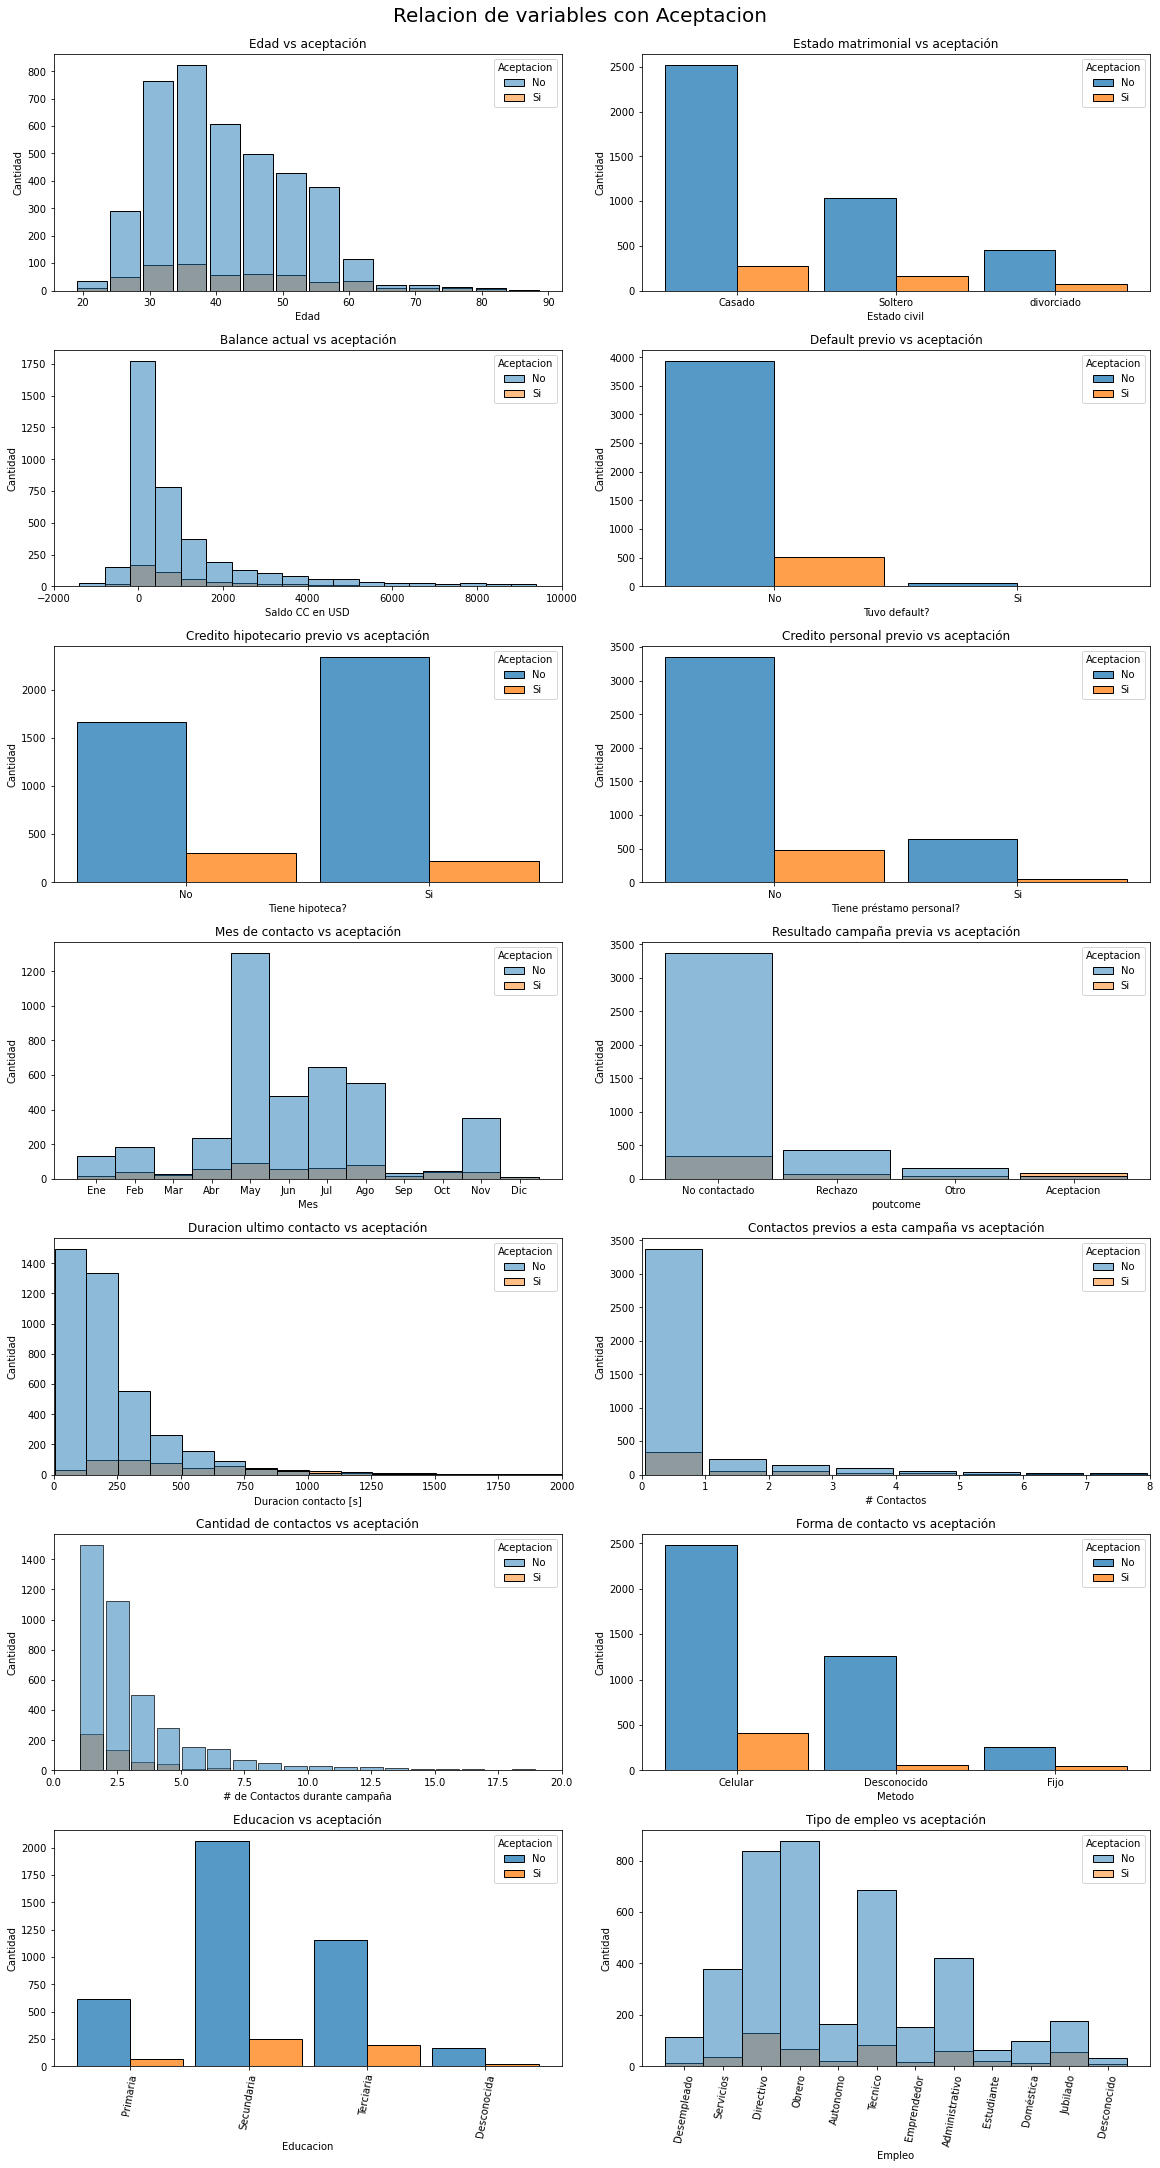

In [42]:
# Generación de gráficos de las variables versus el resultado de las campañas

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2, figsize = (16, 30), constrained_layout = True)
    
plt.suptitle('Relacion de variables con Aceptacion', fontsize = 20)
    
sns.histplot(data = df_marketing, x = 'age', hue = 'Aceptacion', ax = ax1, binwidth = 5, shrink = 0.9)
ax1.set_title('Edad vs aceptación')
ax1.set_ylabel('Cantidad')
ax1.set_xlabel('Edad')

sns.histplot(data = df_marketing, x = 'marital', hue = 'Aceptacion', ax = ax2, multiple = 'dodge', shrink = 0.9)
ax2.set_title('Estado matrimonial vs aceptación')
ax2.set_ylabel('Cantidad')
ax2.set_xlabel('Estado civil')

sns.histplot(data = df_marketing, x = 'balance', hue = 'Aceptacion', ax = ax3, bins = 20, binrange = (-2000, 10000))
ax3.set_xlim(left = -2000, right = 10000)
ax3.set_title('Balance actual vs aceptación')
ax3.set_ylabel('Cantidad')
ax3.set_xlabel('Saldo CC en USD')

sns.histplot(data = df_marketing, x = 'default', hue = 'Aceptacion', ax = ax4, multiple = 'dodge', shrink = 0.9)
ax4.set_title('Default previo vs aceptación')
ax4.set_ylabel('Cantidad')
ax4.set_xlabel('Tuvo default?')

sns.histplot(data = df_marketing, x = 'housing', hue = 'Aceptacion', ax = ax5, multiple = 'dodge', shrink = 0.9)
ax5.set_title('Credito hipotecario previo vs aceptación')
ax5.set_ylabel('Cantidad')
ax5.set_xlabel('Tiene hipoteca?')

sns.histplot(data = df_marketing, x = 'loan', hue = 'Aceptacion', ax = ax6, multiple = 'dodge', shrink = 0.9)
ax6.set_title('Credito personal previo vs aceptación')
ax6.set_ylabel('Cantidad')
ax6.set_xlabel('Tiene préstamo personal?')

sns.histplot(data = df_marketing, x = 'month', hue = 'Aceptacion', ax = ax7)
ax7.set_title('Mes de contacto vs aceptación')
ax7.set_ylabel('Cantidad')
ax7.set_xlabel('Mes')

sns.histplot(data = df_marketing, x = 'poutcome', hue = 'Aceptacion', ax = ax8, shrink = 0.9)
ax8.set_title('Resultado campaña previa vs aceptación')
ax8.set_ylabel('Cantidad')

sns.histplot(data = df_marketing, x = 'duration', hue = 'Aceptacion', ax = ax9, binwidth = 125)
ax9.set_xlim(left = 0, right = 2000)
ax9.margins(0.05, 0.05)
ax9.set_title('Duracion ultimo contacto vs aceptación')
ax9.set_xlabel('Duracion contacto [s]')
ax9.set_ylabel('Cantidad')

sns.histplot(data = df_marketing, x = 'previous', hue = 'Aceptacion', ax = ax10, binwidth = 1, shrink = 0.9)
ax10.set_title('Contactos previos a esta campaña vs aceptación')
ax10.set_xlim(left = 0, right = 8)
ax10.set_xlabel('# Contactos')
ax10.set_ylabel('Cantidad')

sns.histplot(data = df_marketing, x = 'campaign', hue = 'Aceptacion', ax = ax11, binwidth = 1, shrink = 0.9)
ax11.set_xlim(0, 20)
ax11.margins(0.05, 0.05)
ax11.set_title('Cantidad de contactos vs aceptación')
ax11.set_xlabel('# de Contactos durante campaña')
ax11.set_ylabel('Cantidad')

sns.histplot(data = df_marketing, x = 'contact', hue = 'Aceptacion', ax = ax12, shrink = 0.9, multiple = 'dodge')
ax12.set_title('Forma de contacto vs aceptación')
ax12.set_xlabel('Metodo')
ax12.set_ylabel('Cantidad')

sns.histplot(data = df_marketing, x = 'education', hue = 'Aceptacion', ax = ax13, multiple = 'dodge', shrink = 0.9)
plt.sca(ax13)
plt.xticks(rotation = 80)
ax13.set_ylabel('Cantidad')
ax13.set_xlabel('Educacion')
ax13.set_title('Educacion vs aceptación')

sns.histplot(data = df_marketing, x = 'job', hue = 'Aceptacion', ax = ax14)
plt.sca(ax14)
plt.xticks(rotation = 80)
ax14.set_ylabel('Cantidad')
ax14.set_xlabel('Empleo')
ax14.set_title('Tipo de empleo vs aceptación')

plt.show()

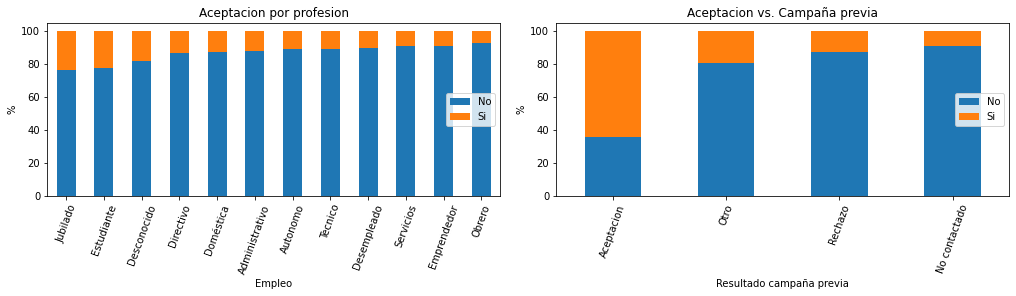

In [43]:
# Agregar graficos de barra en %

df_empleo = df_marketing[['job', 'Aceptacion']].copy()
df_empleo = pd.get_dummies(df_empleo, columns = ['Aceptacion'])
df_empleo = df_empleo.groupby(['job']).sum()
df_empleo['total'] = df_empleo['Aceptacion_No'] + df_empleo['Aceptacion_Si']
df_empleo['Aceptacion_No'] = df_empleo['Aceptacion_No'] / df_empleo['total'] * 100
df_empleo['Aceptacion_Si'] = df_empleo['Aceptacion_Si'] / df_empleo['total'] * 100
df_empleo.drop(columns = ['total'], inplace = True)
#
df_empleo.sort_values(by = ['Aceptacion_Si'], ascending = False, inplace = True)
df_empleo.rename(columns = {'Aceptacion_Si' : 'Si', 'Aceptacion_No' : 'No'}, inplace = True)

df_previo = df_marketing[['poutcome', 'Aceptacion']].copy()
df_previo = pd.get_dummies(df_previo, columns = ['Aceptacion'])
df_previo = df_previo.groupby(['poutcome']).sum()
df_previo['total'] = df_previo['Aceptacion_No'] + df_previo['Aceptacion_Si']
df_previo['Aceptacion_No'] = df_previo['Aceptacion_No'] / df_previo['total'] * 100
df_previo['Aceptacion_Si'] = df_previo['Aceptacion_Si'] / df_previo['total'] * 100
df_previo.drop(columns = ['total'], inplace = True)
#
df_previo.sort_values(by = ['Aceptacion_Si'], ascending = False, inplace = True)
df_previo.rename(columns = {'Aceptacion_Si' : 'Si', 'Aceptacion_No' : 'No'}, inplace = True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4), constrained_layout = True)

df_empleo.plot(kind = 'bar', stacked = True, title = 'Aceptacion por profesion', ax = ax1)
ax1.set_xlabel('Empleo')
ax1.set_ylabel('%')
ax1.legend(loc = 'center right')
plt.sca(ax1)
plt.xticks(rotation = 70)

df_previo.plot(kind = 'bar', stacked = True, title = 'Aceptacion vs. Campaña previa', ax = ax2)
ax2.set_xlabel('Resultado campaña previa')
ax2.set_ylabel('%')
ax2.legend(loc = 'center right')
plt.sca(ax2)
plt.xticks(rotation = 70)

plt.show()

In [44]:
df_previo = df_marketing[['poutcome', 'Aceptacion']].copy()
df_previo = pd.get_dummies(df_previo, columns = ['Aceptacion'])
df_previo

,poutcome,Aceptacion_No,Aceptacion_Si
0,No contactado,1,0
1,Rechazo,1,0
2,Rechazo,1,0
3,No contactado,1,0
4,No contactado,1,0
...,...,...,...
4516,No contactado,1,0
4517,No contactado,1,0
4518,No contactado,1,0
4519,Otro,1,0


Se ven algunos patrones para ver la significancia de las variables: estacionalidad, edad

El feature_importance del modelo seleccionado va a dar la primer pauta.

In [45]:
df_marketing['Aceptacion'].replace(to_replace = ['No', 'Si'], value = [0, 1], inplace = True)

Pasar variable target a numérica para poder correr los modelos

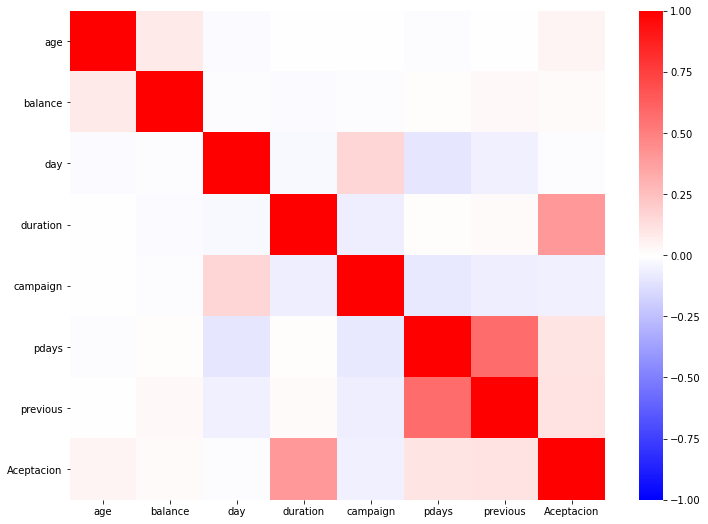

In [46]:
fig, ax1 = plt.subplots(1, 1, figsize = (12, 9))
sns.heatmap(df_marketing.corr(), vmin = -1, vmax = 1, cmap = 'bwr');
plt.yticks(rotation = 0)
plt.show()

A priori las features parecen independientes entre sí.

In [47]:
# Cantidad de elementos dentro de cada variable categórica

lista_col_cat = [x for x in df_marketing.columns if df_marketing[x].dtype != 'int64']
lista_col_num = [x for x in df_marketing.columns if df_marketing[x].dtype == 'int64']

for cat in lista_col_cat:
    print(cat)
    print(df_marketing[cat].unique())
    print()

job
['Desempleado' 'Servicios' 'Directivo' 'Obrero' 'Autonomo' 'Tecnico'
 'Emprendedor' 'Administrativo' 'Estudiante' 'Doméstica' 'Jubilado'
 'Desconocido']

marital
['Casado' 'Soltero' 'divorciado']

education
['Primaria' 'Secundaria' 'Terciaria' 'Desconocida']

default
['No' 'Si']

housing
['No' 'Si']

loan
['No' 'Si']

contact
['Celular' 'Desconocido' 'Fijo']

month
['Oct', 'May', 'Abr', 'Jun', 'Feb', ..., 'Jul', 'Nov', 'Sep', 'Mar', 'Dic']
Length: 12
Categories (12, object): ['Ene' < 'Feb' < 'Mar' < 'Abr' ... 'Sep' < 'Oct' < 'Nov' < 'Dic']

poutcome
['No contactado' 'Rechazo' 'Otro' 'Aceptacion']



In [48]:
len(df_marketing[df_marketing['pdays'] == -1])

3705

In [49]:
len(df_marketing[df_marketing['pdays'] == -1]) / df_marketing.shape[0] * 100

81.95089581950896

El 81% de clientes (3705 en la muestra) no fueron contactados para las campañas anteriores; esta es su primera vez

## Preprocesamiento de dataset

In [50]:
def prepocesser (data):
    lista_col_cat = [x for x in data.columns if data[x].dtype != 'int64']
    lista_col_num = [x for x in data.columns if data[x].dtype == 'int64']
    encoder_categories = []
    
    for col in lista_col_cat:    
        col_categories = data[col].unique()
        encoder_categories.append(col_categories)
    
    encoder = OneHotEncoder(categories = encoder_categories, sparse = False, handle_unknown = 'ignore')
    
    df_encoded = encoder.fit_transform(data[lista_col_cat])
    df_encoded_categorical = pd.DataFrame(df_encoded, columns = encoder.get_feature_names(lista_col_cat))
    
    scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(data[lista_col_num])
    df_scaled_numerical = pd.DataFrame(df_scaled, columns = lista_col_num)
    
    df_prepocesed = df_encoded_categorical.join(df_scaled_numerical, how = 'left')
    return df_prepocesed

In [51]:
df_prepocesed = prepocesser(df_marketing)

Corrida de OneHotEncoder y MinMax scaler para preprocesar los datos, se deja handle_unknown abierto por si aparecieran features nuevas

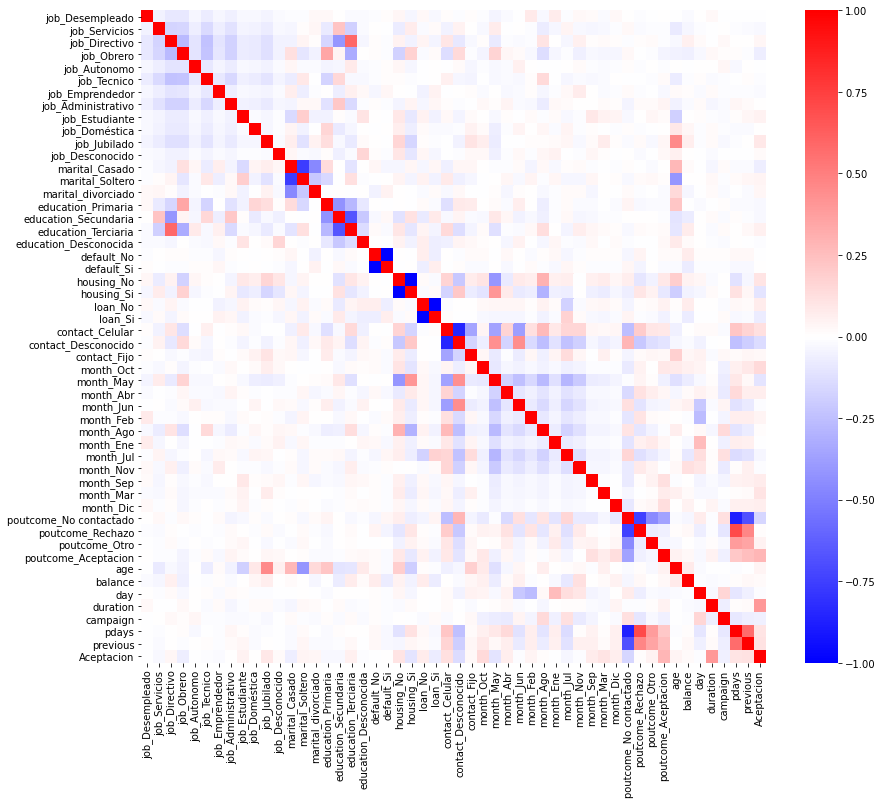

In [52]:
fig, ax1 = plt.subplots(1, 1, figsize = (14, 12))
sns.heatmap(df_prepocesed.corr(), vmin = -1, vmax = 1, cmap = 'bwr');
plt.show()

Matriz de correlación de todas las features, hay algunas correlaciones entre variables (poutcome con pdays, previous) y entre dummies nacidas de la misma variable categórica, pero no hay patrones que sugieran multicolinealidad

## Primer enfoque: Modelos de predicción con reducción de features

Función general que corre un diccionario de modelos, entrega y grafica resultados

In [53]:
def run_models(models, X_train, X_test, y_train, y_test):

    data_models = []
    
    for key, value in models.items():
        
        # Selección de modelo y inicio del temporizados
        t_start = process_time() 
        model = value
        
        # Fit del modelo y predicciones
        model.fit(X_train, np.ravel(y_train))
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        print('Modelo: ', key)
        print('---------------------------------')
        
        # Calculo de las métricas del modelo
        print(classification_report(y_test, y_pred))
        
        recall_val = round(recall_score(y_test, y_pred, average = 'micro'), 4)
        prec_score = round(precision_score(y_test, y_pred, pos_label = 1, average = 'binary'), 4)
        roc_score =  round(roc_auc_score(y_test, y_pred), 4)
        
        pos_class_recall = round(recall_score(y_test, y_pred, pos_label = 1, average = 'binary'), 4)
        pos_class_prec = round(average_precision_score(y_test, y_pred_proba[:,1]), 4)
        
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        
        #Preparación de datos y curvas ROC, PR
        prec, rec, thr = precision_recall_curve(y_test, y_pred_proba[:,1])
        df1 = pd.DataFrame(dict(fpr = prec, tpr = rec))
        prec, rec, thr = roc_curve(y_test, y_pred_proba[:,1])
        df2 = pd.DataFrame(dict(fpr = prec, tpr = rec, thr = thr))
        
        # Graficas de ROC y PR
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7))
     
        fig.suptitle(f'Curva Precision-Recall & ROC para {key} \n', fontsize = 14)
    
        ax1.axis([0, 1.01, 0, 1.01])
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title(f'Curva Precision-Recall para {key} \n')
        ax1.plot(df1['fpr'],df1['tpr'])
        ax1.plot(np.arange(0, 1, step = 0.01), np.arange(1, 0, step = -0.01))
        
        ax2.axis([0, 1.01, 0, 1.01])
        ax2.set_xlabel('1 - Specificty')
        ax2.set_ylabel('TPR / Sensitivity')
        ax2.set_title(f'Curva ROC para {key} \n')
        ax2.plot(df2['fpr'],df2['tpr'])
        ax2.plot(np.arange(0, 1, step = 0.01), np.arange(0, 1, step = 0.01))
        
        plt.show()
        
        print('\n')
        print('Area under Prec-Recall curve (AUC PR):', prec_score)
        print('Area under ROC curve (AUC ROC):', roc_score)
        print('\n')
        
        # Extracción de las feature importance de cada modelo
        if hasattr(model, 'feature_importances_'):
            features = pd.Series(data = model.feature_importances_, index = X_train.columns)
            features.sort_values(ascending = False, inplace = True)    
            features_plot = features.head(15)
            features_plot.plot(kind = 'barh', figsize = (13, 7), title = f'Top 15 Feature importance para {key}')
            plt.show()
        elif hasattr(model, 'coef_'):
            features = pd.Series(data = abs(model.coef_[0, :]), index = X_train.columns)
            features.sort_values(ascending = False, inplace = True)
            features_plot = features.head(15)
            features_plot.plot(kind = 'barh', figsize = (13, 7), title = f'Top 15 Feature importance para {key}')
            plt.show()
        
        # Fin del temporizador y cálculo de tiempo de performance
        t_end = process_time()
        time_to_process = t_end - t_start
        
        #Carga de resultados a serie
        data_model_run = pd.Series(data = [pos_class_recall, pos_class_prec, prec_score, roc_score, train_score, test_score, time_to_process], \
                                   index = ['+ class Recall', '+ class Precission', 'AUC PR', 'AUC ROC', 'Train Score', 'Test Score', 'Time to Process'],\
                                   name = key)
        data_models.append(data_model_run)
        
        print('\n')
        print('+++++++++++++++')
        print('\n')
    
    #Carga de resultados al dataframe
    data_models = pd.DataFrame(data = data_models, columns = \
                               ['+ class Recall', '+ class Precission', 'AUC PR', 'AUC ROC', 'Train Score', 'Test Score', 'Time to Process'])
    return data_models

### Primera corrida: 6 modelos de clasificación, sin selección de features

In [54]:
model_LogReg = LogisticRegression(max_iter = 300)
model_KNC = KNeighborsClassifier(n_neighbors = 10)
model_GNB = GaussianNB()
model_NN = MLPClassifier(max_iter = 800)
model_RF = RandomForestClassifier(min_samples_leaf = 3)
model_DT = DecisionTreeClassifier(min_samples_leaf = 3)
model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
models = {'Logistic Regression' : model_LogReg, 'K Neighbors Classifier' : model_KNC, 'Gaussian Naive Bayes' : model_GNB, 'Neural Network' : model_NN,\
          'Random Forest' : model_RF, 'Decision Tree' : model_DT, 'Gradient Boost Classifier' : model_GBC}

Diccionario de modelos, con sus parámetros por default en su mayoría

In [55]:
# dividir dataset entre X e y
target = 'Aceptacion'
y = df_prepocesed[target].copy()
X = df_prepocesed.loc[:, df_prepocesed.columns != target].copy()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

División entre test/train, estratificando según y

Modelo:  Logistic Regression
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      1201
         1.0       0.63      0.22      0.32       156

    accuracy                           0.90      1357
   macro avg       0.77      0.60      0.63      1357
weighted avg       0.87      0.90      0.87      1357



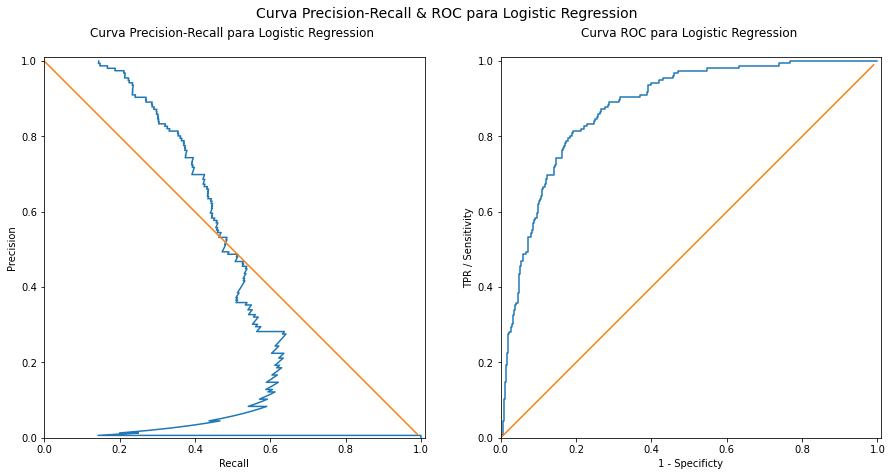



Area under Prec-Recall curve (AUC PR): 0.6296
Area under ROC curve (AUC ROC): 0.6006




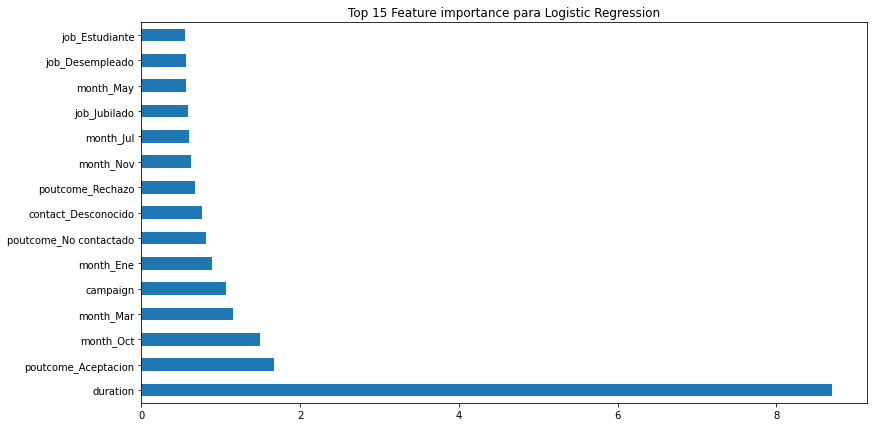



+++++++++++++++


Modelo:  K Neighbors Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      1201
         1.0       0.58      0.04      0.08       156

    accuracy                           0.89      1357
   macro avg       0.74      0.52      0.51      1357
weighted avg       0.85      0.89      0.84      1357



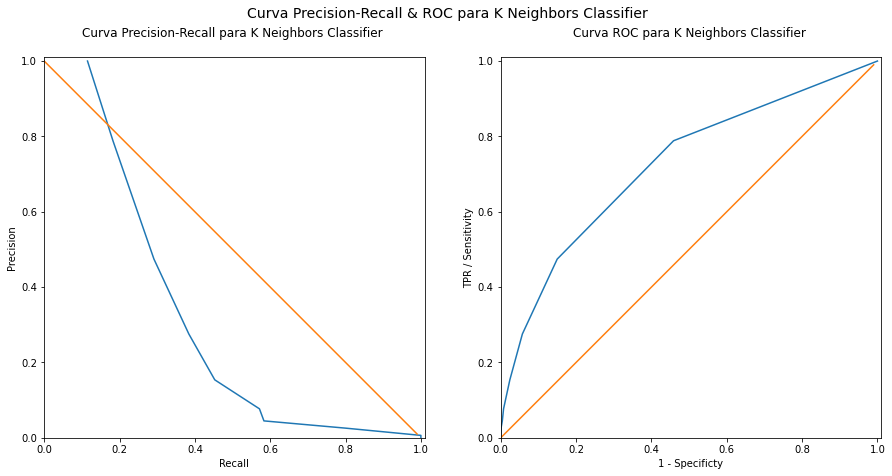



Area under Prec-Recall curve (AUC PR): 0.5833
Area under ROC curve (AUC ROC): 0.5204




+++++++++++++++


Modelo:  Gaussian Naive Bayes
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89      1201
         1.0       0.29      0.41      0.34       156

    accuracy                           0.82      1357
   macro avg       0.61      0.64      0.62      1357
weighted avg       0.85      0.82      0.83      1357



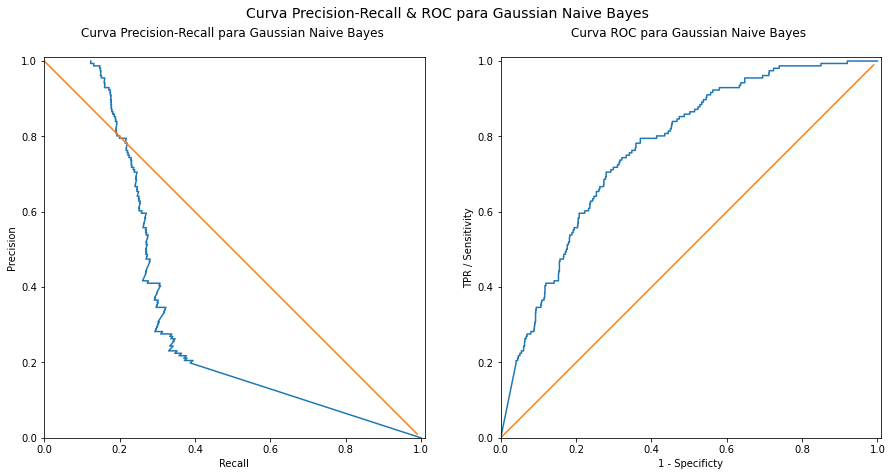



Area under Prec-Recall curve (AUC PR): 0.2922
Area under ROC curve (AUC ROC): 0.6406




+++++++++++++++


Modelo:  Neural Network
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1201
         1.0       0.50      0.36      0.42       156

    accuracy                           0.89      1357
   macro avg       0.71      0.66      0.68      1357
weighted avg       0.87      0.89      0.88      1357



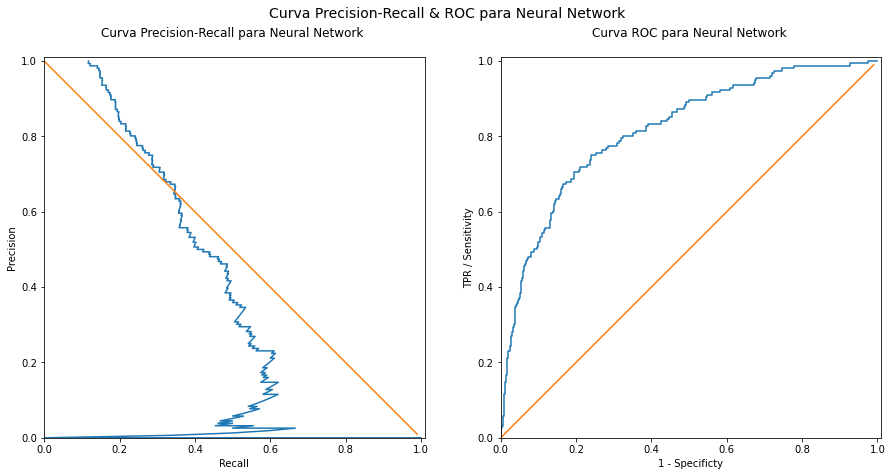



Area under Prec-Recall curve (AUC PR): 0.5
Area under ROC curve (AUC ROC): 0.6562




+++++++++++++++


Modelo:  Random Forest
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      1201
         1.0       0.55      0.15      0.24       156

    accuracy                           0.89      1357
   macro avg       0.72      0.57      0.59      1357
weighted avg       0.86      0.89      0.86      1357



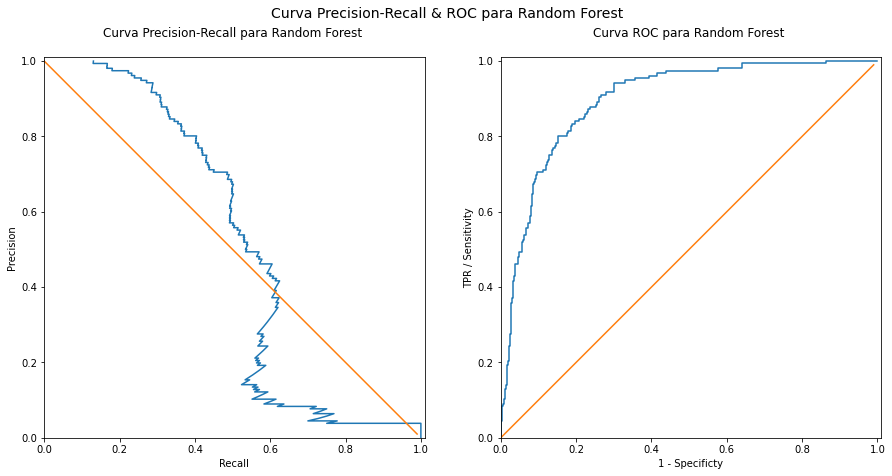



Area under Prec-Recall curve (AUC PR): 0.5455
Area under ROC curve (AUC ROC): 0.5686




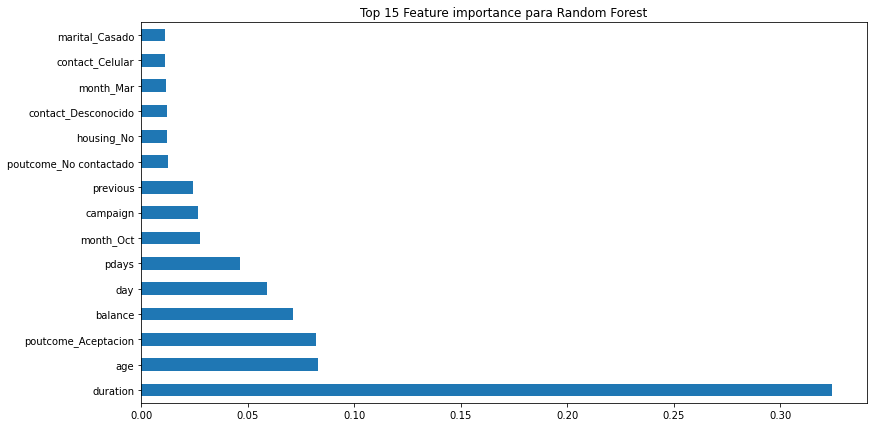



+++++++++++++++


Modelo:  Decision Tree
---------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1201
         1.0       0.44      0.46      0.45       156

    accuracy                           0.87      1357
   macro avg       0.68      0.69      0.69      1357
weighted avg       0.87      0.87      0.87      1357



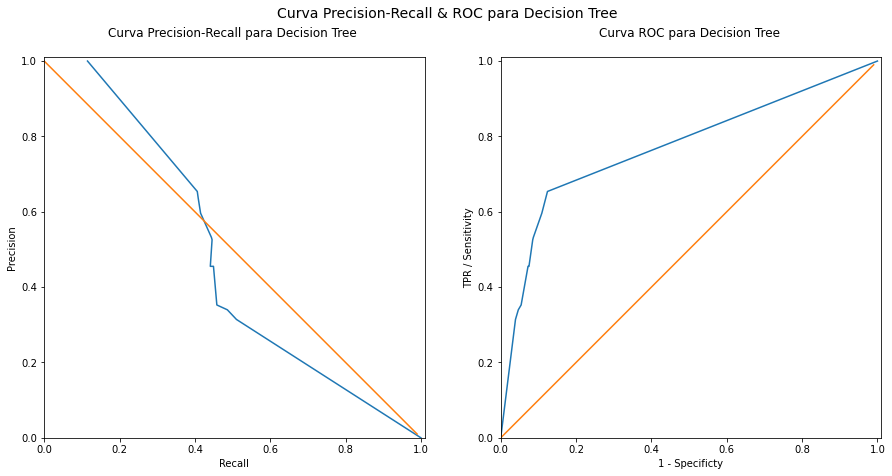



Area under Prec-Recall curve (AUC PR): 0.441
Area under ROC curve (AUC ROC): 0.6901




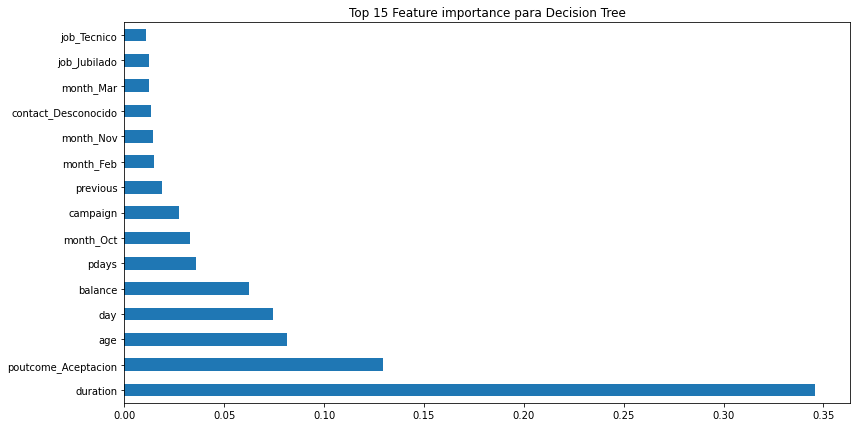



+++++++++++++++


Modelo:  Gradient Boost Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1201
         1.0       0.56      0.13      0.21       156

    accuracy                           0.89      1357
   macro avg       0.73      0.56      0.57      1357
weighted avg       0.86      0.89      0.86      1357



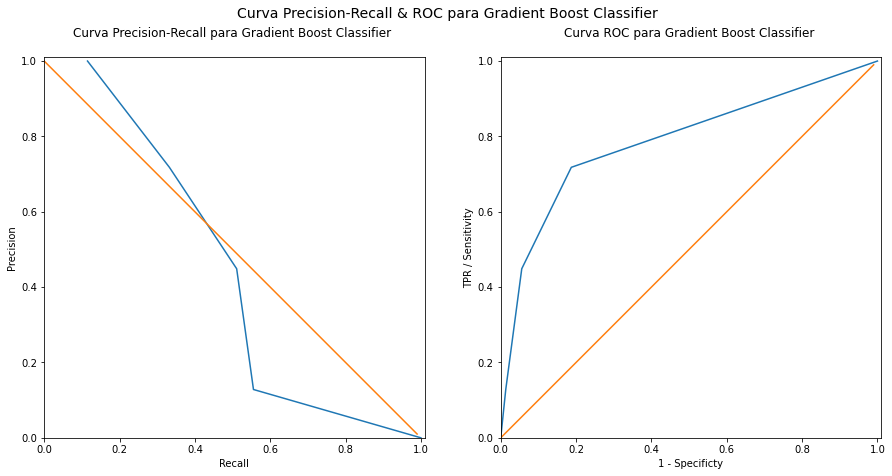



Area under Prec-Recall curve (AUC PR): 0.5556
Area under ROC curve (AUC ROC): 0.5574




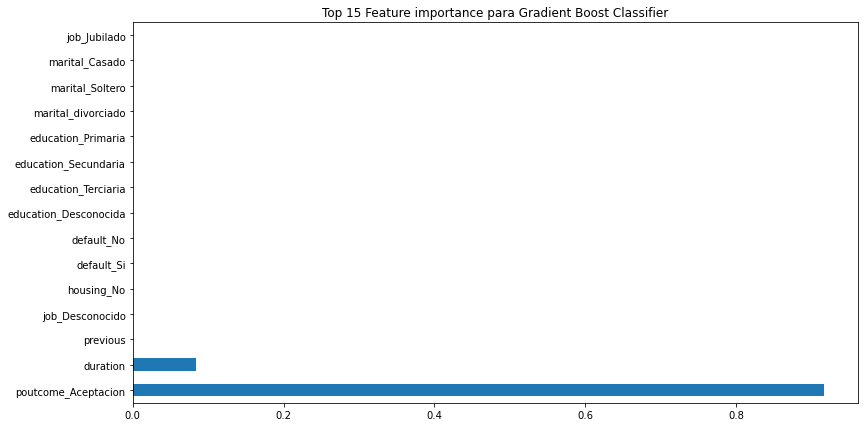



+++++++++++++++




In [57]:
data_model = run_models(models, X_train, X_test, y_train, y_test)

In [58]:
data_model.sort_values(by = '+ class Recall', ascending = False)

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Decision Tree,0.4551,0.3490,0.4410,0.6901,0.962073,0.871039,1.000000
Gaussian Naive Bayes,0.4103,0.2791,0.2922,0.6406,0.851454,0.817981,0.921875
Neural Network,0.3590,0.4051,0.5000,0.6562,0.991783,0.885041,36.109375
Logistic Regression,0.2179,0.4599,0.6296,0.6006,0.904551,0.895357,1.531250
Random Forest,0.1538,0.5200,0.5455,0.5686,0.943110,0.887988,1.640625
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.500000
K Neighbors Classifier,0.0449,0.2725,0.5833,0.5204,0.893489,0.886514,3.843750


Aunque los puntajes de test/train son relativamente altos (0.90 en gral) los puntajes de las curvas ROC y PR son bajos; también son bajas las métricas referidas a la predicción de la clase 1 (o +), que también son importantes para ver el ajuste en problemas con clases desbalanceadas

In [59]:
X_train.columns.to_list()

['job_Desempleado',
 'job_Servicios',
 'job_Directivo',
 'job_Obrero',
 'job_Autonomo',
 'job_Tecnico',
 'job_Emprendedor',
 'job_Administrativo',
 'job_Estudiante',
 'job_Doméstica',
 'job_Jubilado',
 'job_Desconocido',
 'marital_Casado',
 'marital_Soltero',
 'marital_divorciado',
 'education_Primaria',
 'education_Secundaria',
 'education_Terciaria',
 'education_Desconocida',
 'default_No',
 'default_Si',
 'housing_No',
 'housing_Si',
 'loan_No',
 'loan_Si',
 'contact_Celular',
 'contact_Desconocido',
 'contact_Fijo',
 'month_Oct',
 'month_May',
 'month_Abr',
 'month_Jun',
 'month_Feb',
 'month_Ago',
 'month_Ene',
 'month_Jul',
 'month_Nov',
 'month_Sep',
 'month_Mar',
 'month_Dic',
 'poutcome_No contactado',
 'poutcome_Rechazo',
 'poutcome_Otro',
 'poutcome_Aceptacion',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

### Segunda corrida: 6 modelos de clasificación, con selección de features

Feature engineering, tomando las variables que pesan más en el resultado.

In [60]:
var_significativas = [
    'duration',
    'poutcome',
    'age',
    'month',
    'balance',
    'pdays',
    'campaign',
    'previous',
    'housing',
    'default',
    'Aceptacion'
]

df_filtered = df_marketing.loc[:, var_significativas].copy()

In [61]:
df_filt_processed = prepocesser(df_filtered)

Preprocesado del dataset filtrado

In [62]:
# dividir dataset entre X e y
target = 'Aceptacion'
y = df_filt_processed[target].copy()
X = df_filt_processed.loc[:, df_filt_processed.columns != target].copy()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [64]:
model_LogReg = LogisticRegression(max_iter = 300)
model_KNC = KNeighborsClassifier(n_neighbors = 10)
model_GNB = GaussianNB()
model_NN = MLPClassifier(max_iter = 800)
model_RF = RandomForestClassifier(min_samples_leaf = 3)
model_DT = DecisionTreeClassifier(min_samples_leaf = 3)
model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
models = {'Logistic Regression' : model_LogReg, 'K Neighbors Classifier' : model_KNC, 'Gaussian Naive Bayes' : model_GNB, 'Neural Network' : model_NN,\
          'Random Forest' : model_RF, 'Decision Tree' : model_DT, 'Gradient Boost Classifier' : model_GBC}

Corrida del mismo diccionario de modelos con el dataset filtrado

Modelo:  Logistic Regression
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      1201
         1.0       0.62      0.20      0.30       156

    accuracy                           0.89      1357
   macro avg       0.76      0.59      0.62      1357
weighted avg       0.87      0.89      0.87      1357



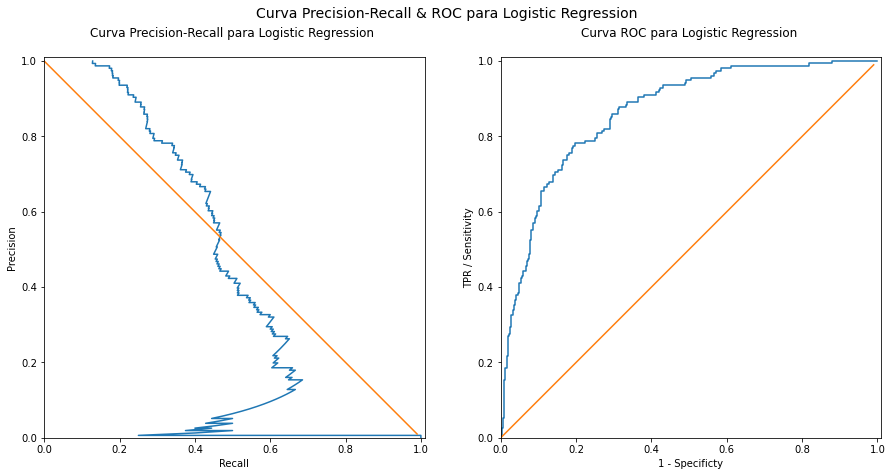



Area under Prec-Recall curve (AUC PR): 0.62
Area under ROC curve (AUC ROC): 0.5914




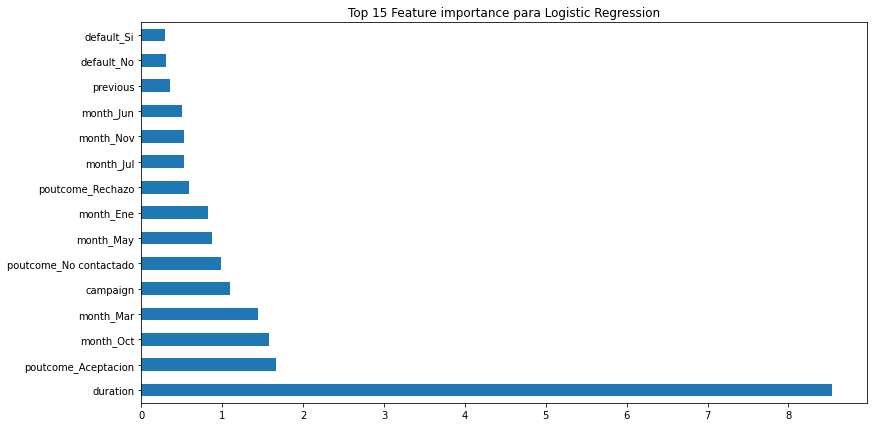



+++++++++++++++


Modelo:  K Neighbors Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1201
         1.0       0.59      0.14      0.23       156

    accuracy                           0.89      1357
   macro avg       0.75      0.56      0.58      1357
weighted avg       0.86      0.89      0.86      1357



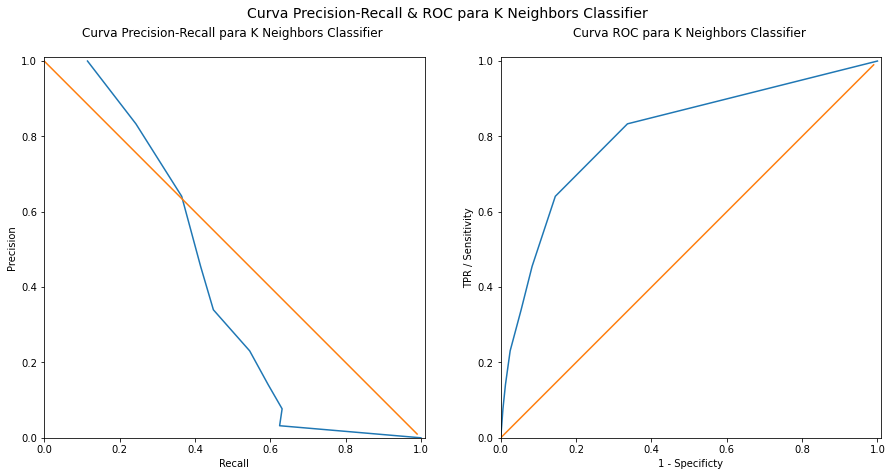



Area under Prec-Recall curve (AUC PR): 0.5946
Area under ROC curve (AUC ROC): 0.5643




+++++++++++++++


Modelo:  Gaussian Naive Bayes
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1201
         1.0       0.33      0.33      0.33       156

    accuracy                           0.85      1357
   macro avg       0.62      0.62      0.62      1357
weighted avg       0.85      0.85      0.85      1357



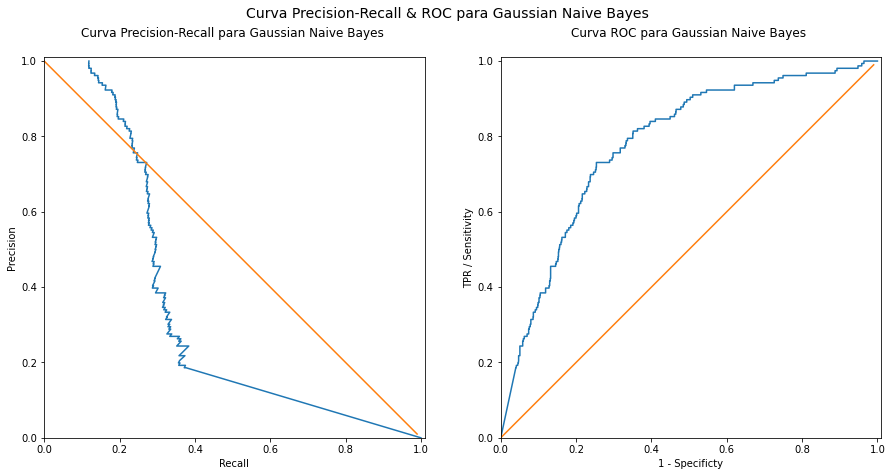



Area under Prec-Recall curve (AUC PR): 0.3291
Area under ROC curve (AUC ROC): 0.6225




+++++++++++++++


Modelo:  Neural Network
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1201
         1.0       0.49      0.35      0.41       156

    accuracy                           0.88      1357
   macro avg       0.70      0.65      0.67      1357
weighted avg       0.87      0.88      0.88      1357



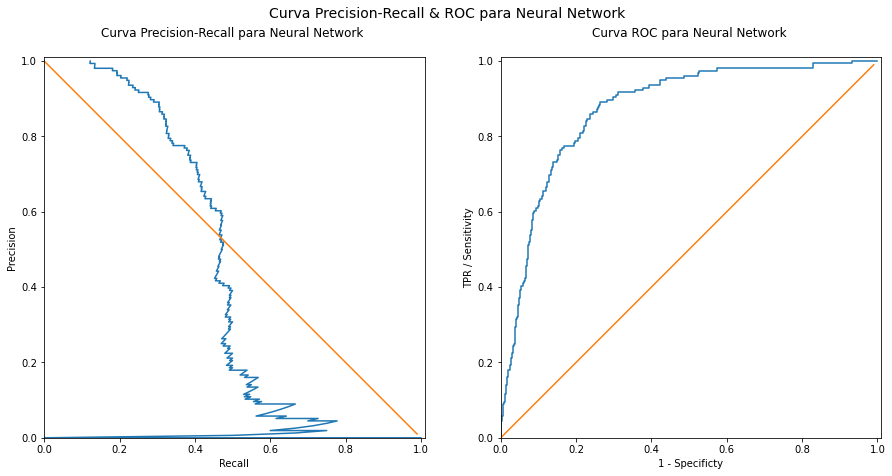



Area under Prec-Recall curve (AUC PR): 0.4911
Area under ROC curve (AUC ROC): 0.6526




+++++++++++++++


Modelo:  Random Forest
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      1201
         1.0       0.52      0.20      0.29       156

    accuracy                           0.89      1357
   macro avg       0.71      0.59      0.61      1357
weighted avg       0.86      0.89      0.86      1357



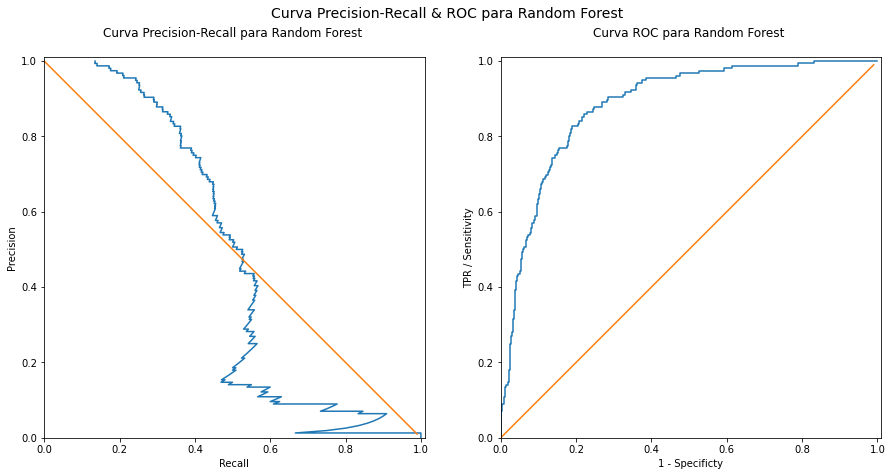



Area under Prec-Recall curve (AUC PR): 0.5167
Area under ROC curve (AUC ROC): 0.5873




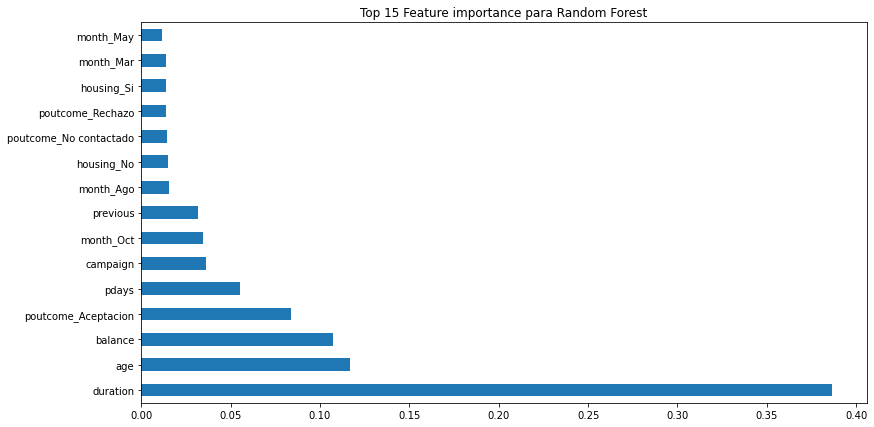



+++++++++++++++


Modelo:  Decision Tree
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      1201
         1.0       0.47      0.39      0.43       156

    accuracy                           0.88      1357
   macro avg       0.70      0.67      0.68      1357
weighted avg       0.87      0.88      0.87      1357



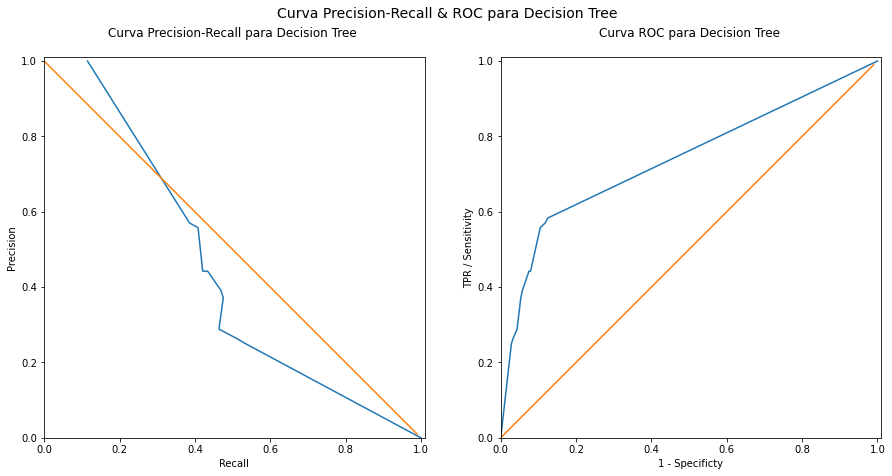



Area under Prec-Recall curve (AUC PR): 0.4692
Area under ROC curve (AUC ROC): 0.6668




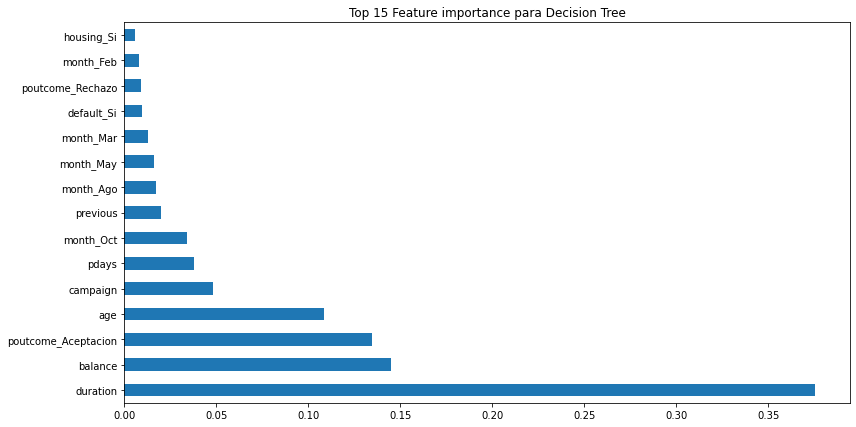



+++++++++++++++


Modelo:  Gradient Boost Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1201
         1.0       0.56      0.13      0.21       156

    accuracy                           0.89      1357
   macro avg       0.73      0.56      0.57      1357
weighted avg       0.86      0.89      0.86      1357



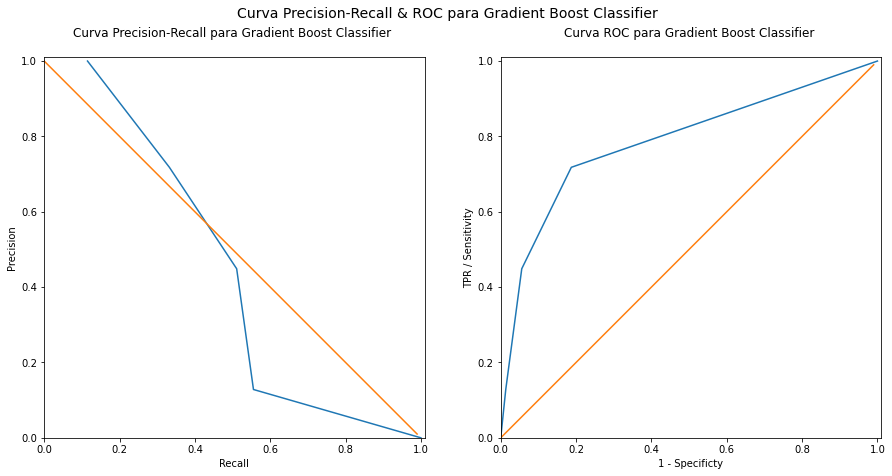



Area under Prec-Recall curve (AUC PR): 0.5556
Area under ROC curve (AUC ROC): 0.5574




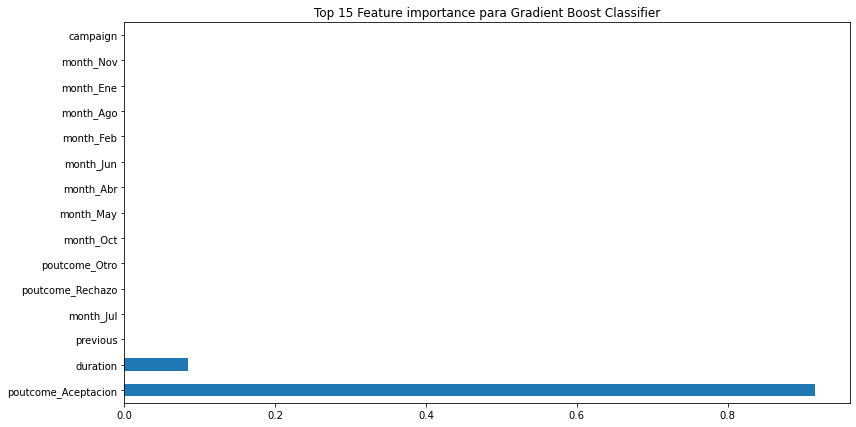



+++++++++++++++




In [65]:
data_model_filt = run_models(models, X_train, X_test, y_train, y_test)

In [66]:
data_model_filt

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.1987,0.4552,0.6200,0.5914,0.901391,0.893884,1.656250
K Neighbors Classifier,0.1410,0.3661,0.5946,0.5643,0.902023,0.890199,1.515625
Gaussian Naive Bayes,0.3333,0.2894,0.3291,0.6225,0.870101,0.845247,0.781250
Neural Network,0.3526,0.4455,0.4911,0.6526,0.941846,0.883567,32.125000
Random Forest,0.1987,0.4885,0.5167,0.5873,0.948483,0.886514,2.203125
Decision Tree,0.3910,0.3277,0.4692,0.6668,0.957965,0.879145,1.093750
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.843750


En vez de mejorar, los resultados empeoraron levemente. En particular las métricas de clase 1

### Tercera corrida: 6 modelos de clasificación, con selección más fina de features, tomando las variables post-preprocesamaiento

In [67]:
var_significativas_2 = [
    'duration',
    'balance',
    'poutcome_Aceptacion',
    'campaign',
    'pdays',
    'previous',
    'month_Oct',
    'month_Ago',
    'month_May',
    'month_Mar',
    'month_Sep',
    'month_Dic',
    'Aceptacion'
]

df_filtered_2 = df_prepocesed.loc[:, var_significativas_2].copy()

In [68]:
# dividir dataset entre X e y
target = 'Aceptacion'
y = df_filtered_2[target].copy()
X = df_filtered_2.loc[:, df_filtered_2.columns != target].copy()

El dataset ya está preprocesado, sólo se seleccionan las features más importantes según la corrida anterior

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [70]:
model_LogReg = LogisticRegression(max_iter = 300)
model_KNC = KNeighborsClassifier(n_neighbors = 10)
model_GNB = GaussianNB()
model_NN = MLPClassifier(max_iter = 800)
model_RF = RandomForestClassifier(min_samples_leaf = 3)
model_DT = DecisionTreeClassifier(min_samples_leaf = 3)
model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
models = {'Logistic Regression' : model_LogReg, 'K Neighbors Classifier' : model_KNC, 'Gaussian Naive Bayes' : model_GNB, 'Neural Network' : model_NN,\
          'Random Forest' : model_RF, 'Decision Tree' : model_DT, 'Gradient Boost Classifier' : model_GBC}

Modelo:  Logistic Regression
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      1201
         1.0       0.58      0.18      0.27       156

    accuracy                           0.89      1357
   macro avg       0.74      0.58      0.61      1357
weighted avg       0.87      0.89      0.86      1357



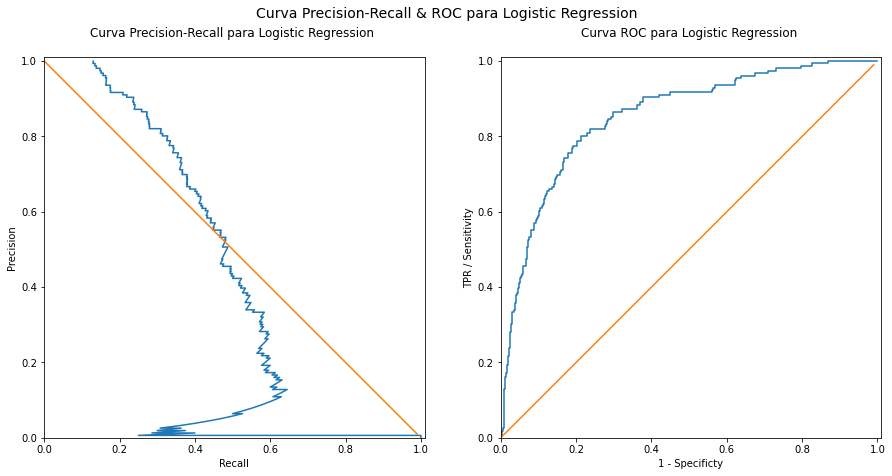



Area under Prec-Recall curve (AUC PR): 0.5833
Area under ROC curve (AUC ROC): 0.5814




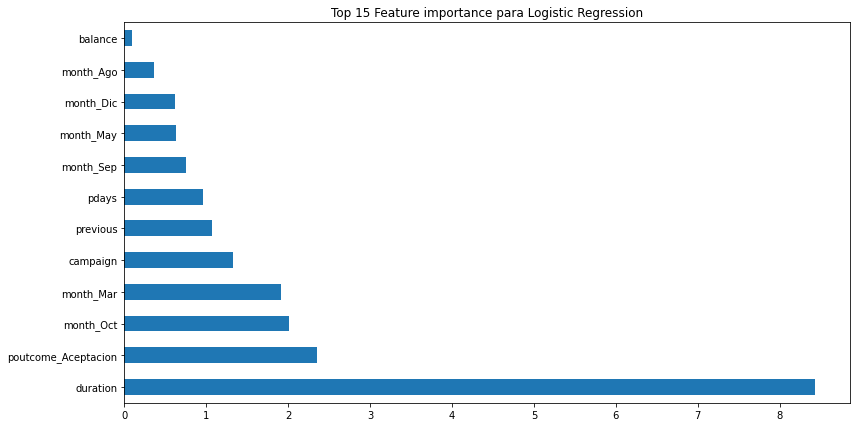



+++++++++++++++


Modelo:  K Neighbors Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1201
         1.0       0.54      0.28      0.37       156

    accuracy                           0.89      1357
   macro avg       0.73      0.63      0.66      1357
weighted avg       0.87      0.89      0.87      1357



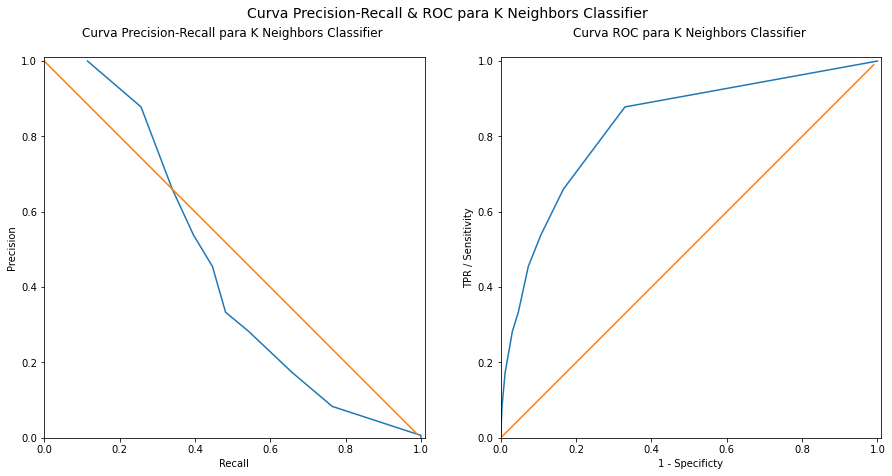



Area under Prec-Recall curve (AUC PR): 0.5432
Area under ROC curve (AUC ROC): 0.6256




+++++++++++++++


Modelo:  Gaussian Naive Bayes
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1201
         1.0       0.36      0.30      0.33       156

    accuracy                           0.86      1357
   macro avg       0.64      0.62      0.62      1357
weighted avg       0.85      0.86      0.85      1357



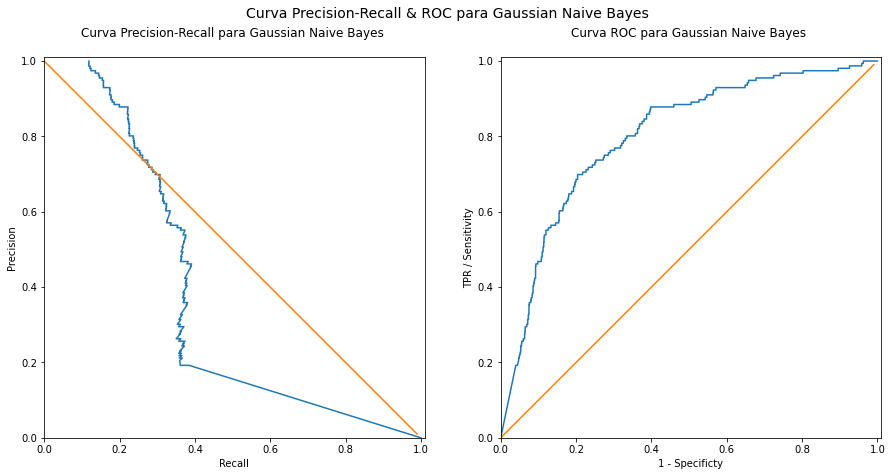



Area under Prec-Recall curve (AUC PR): 0.3615
Area under ROC curve (AUC ROC): 0.6161




+++++++++++++++


Modelo:  Neural Network
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1201
         1.0       0.56      0.26      0.35       156

    accuracy                           0.89      1357
   macro avg       0.74      0.62      0.65      1357
weighted avg       0.87      0.89      0.87      1357



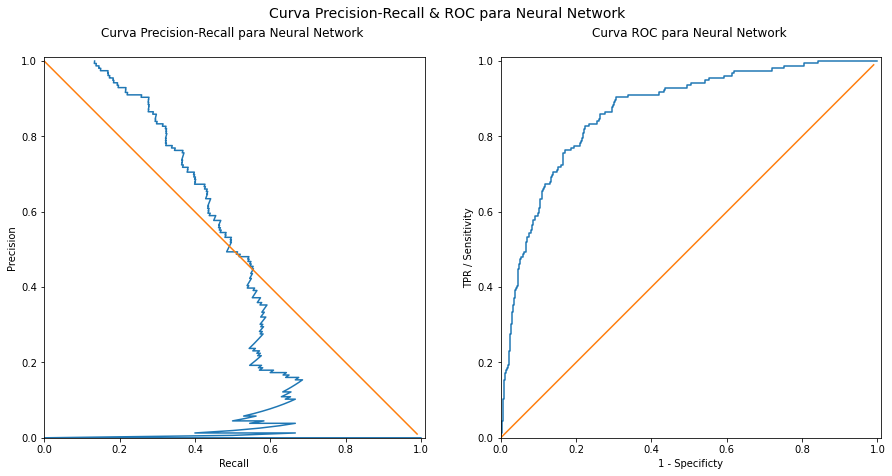



Area under Prec-Recall curve (AUC PR): 0.5634
Area under ROC curve (AUC ROC): 0.6153




+++++++++++++++


Modelo:  Random Forest
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      1201
         1.0       0.58      0.27      0.37       156

    accuracy                           0.89      1357
   macro avg       0.74      0.62      0.65      1357
weighted avg       0.87      0.89      0.88      1357



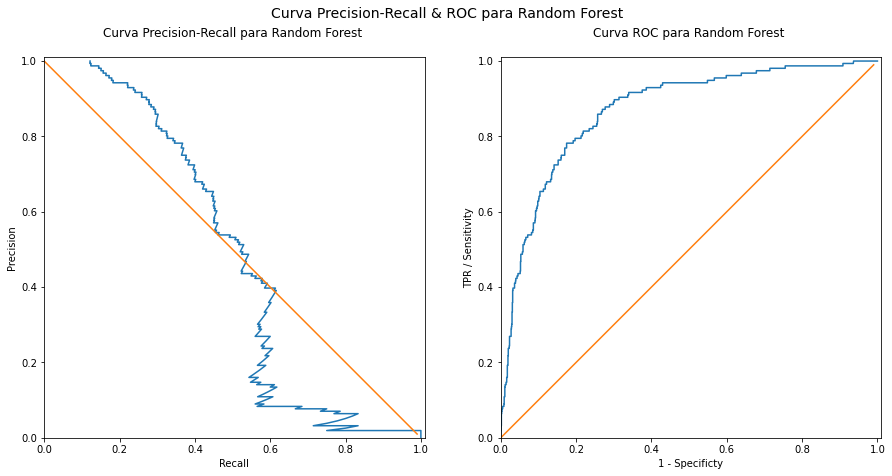



Area under Prec-Recall curve (AUC PR): 0.5753
Area under ROC curve (AUC ROC): 0.6217




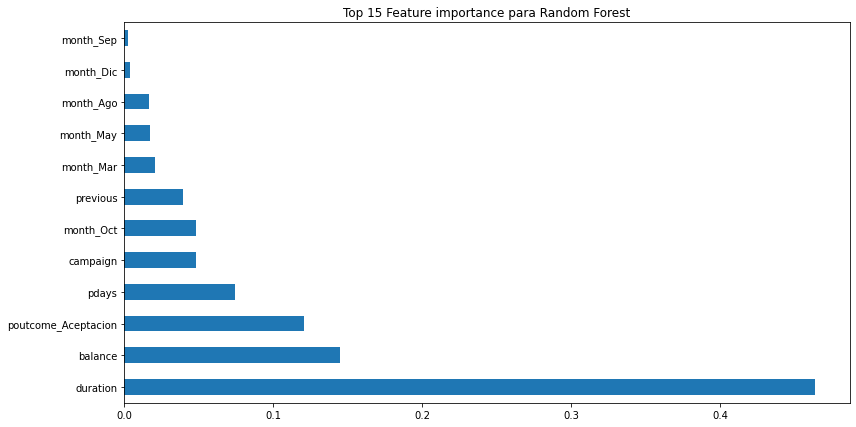



+++++++++++++++


Modelo:  Decision Tree
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      1201
         1.0       0.46      0.40      0.42       156

    accuracy                           0.88      1357
   macro avg       0.69      0.67      0.68      1357
weighted avg       0.87      0.88      0.87      1357



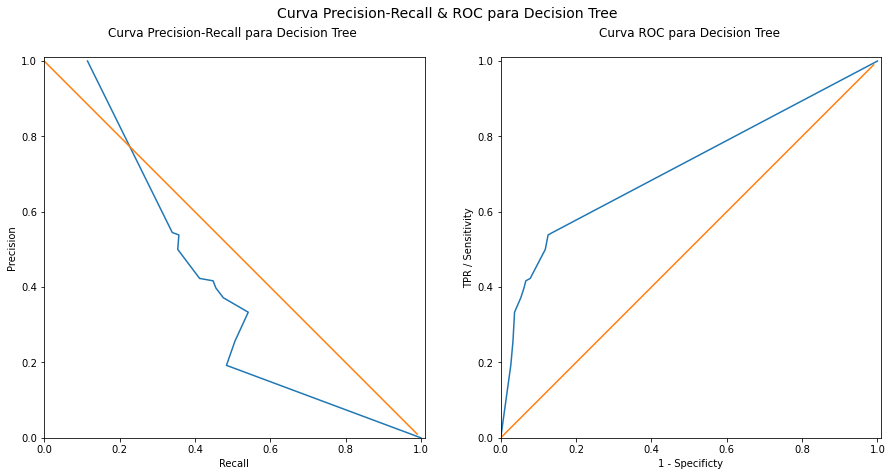



Area under Prec-Recall curve (AUC PR): 0.4559
Area under ROC curve (AUC ROC): 0.6679




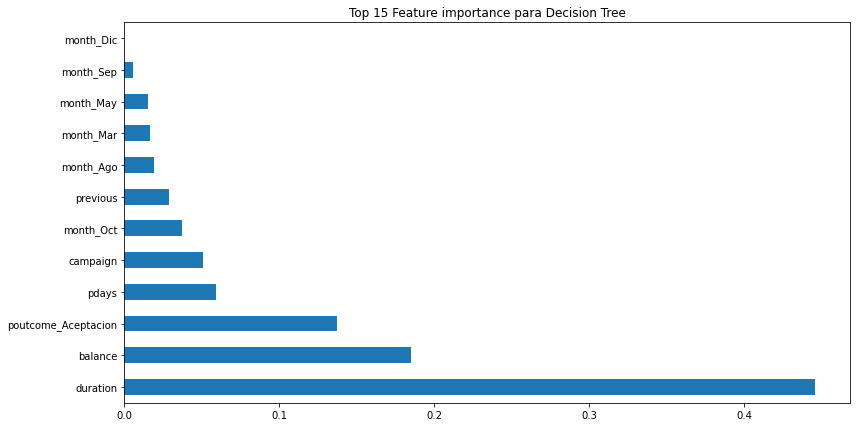



+++++++++++++++


Modelo:  Gradient Boost Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1201
         1.0       0.56      0.13      0.21       156

    accuracy                           0.89      1357
   macro avg       0.73      0.56      0.57      1357
weighted avg       0.86      0.89      0.86      1357



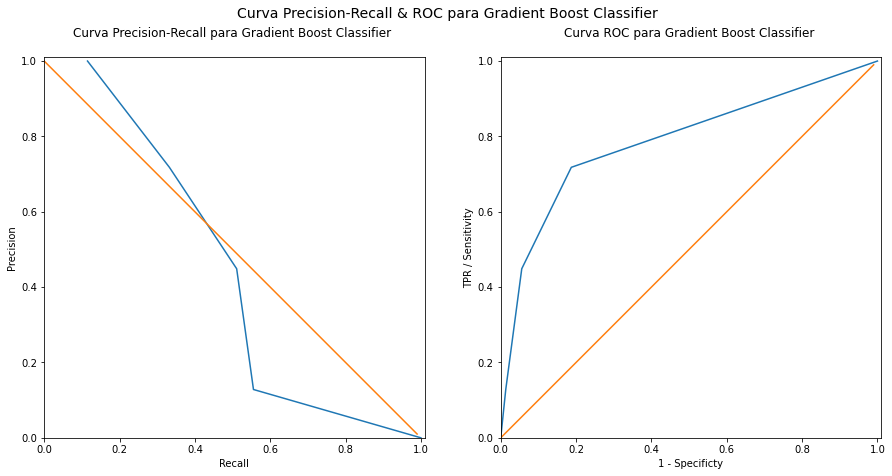



Area under Prec-Recall curve (AUC PR): 0.5556
Area under ROC curve (AUC ROC): 0.5574




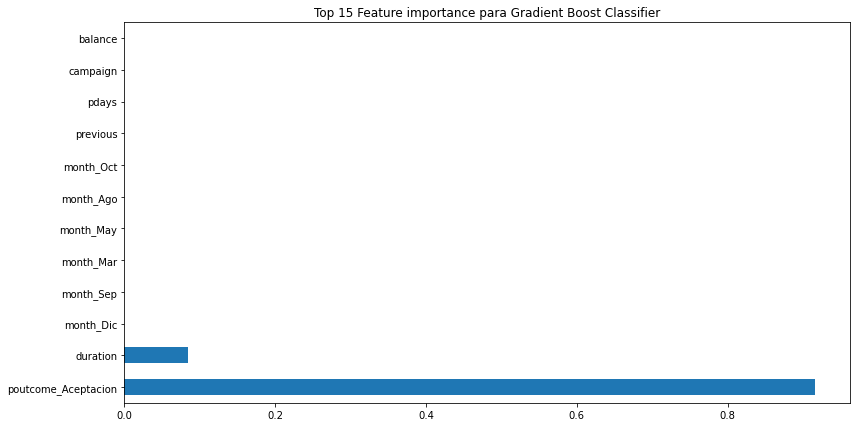



+++++++++++++++




In [71]:
data_model_filt_2 = run_models(models, X_train, X_test, y_train, y_test)

In [72]:
data_model_filt_2

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.1795,0.4420,0.5833,0.5814,0.900759,0.890936,1.875000
K Neighbors Classifier,0.2821,0.4071,0.5432,0.6256,0.910240,0.890199,1.812500
Gaussian Naive Bayes,0.3013,0.3180,0.3615,0.6161,0.885904,0.858511,0.687500
Neural Network,0.2564,0.4660,0.5634,0.6153,0.911820,0.891673,16.406250
Random Forest,0.2692,0.4885,0.5753,0.6217,0.940898,0.893147,1.296875
Decision Tree,0.3974,0.3039,0.4559,0.6679,0.956700,0.876197,0.890625
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.125000


In [73]:
data_model_filt

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.1987,0.4552,0.6200,0.5914,0.901391,0.893884,1.656250
K Neighbors Classifier,0.1410,0.3661,0.5946,0.5643,0.902023,0.890199,1.515625
Gaussian Naive Bayes,0.3333,0.2894,0.3291,0.6225,0.870101,0.845247,0.781250
Neural Network,0.3526,0.4455,0.4911,0.6526,0.941846,0.883567,32.125000
Random Forest,0.1987,0.4885,0.5167,0.5873,0.948483,0.886514,2.203125
Decision Tree,0.3910,0.3277,0.4692,0.6668,0.957965,0.879145,1.093750
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.843750


In [74]:
data_model

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.2179,0.4599,0.6296,0.6006,0.904551,0.895357,1.531250
K Neighbors Classifier,0.0449,0.2725,0.5833,0.5204,0.893489,0.886514,3.843750
Gaussian Naive Bayes,0.4103,0.2791,0.2922,0.6406,0.851454,0.817981,0.921875
Neural Network,0.3590,0.4051,0.5000,0.6562,0.991783,0.885041,36.109375
Random Forest,0.1538,0.5200,0.5455,0.5686,0.943110,0.887988,1.640625
Decision Tree,0.4551,0.3490,0.4410,0.6901,0.962073,0.871039,1.000000
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.500000


Mirando los resultados de las corridas, el reducir la cantidad de features no mejora significativamente la performance del modelo

## Segundo enfoque: Modelos de predicción con oversampling

Corrida con SMOTENC

In [104]:
#Filtrado de variables categóricas

lista_col_cat = [df_marketing[x].dtype != 'int64' for x in df_marketing.columns]
lista_col_cat

[False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False]

In [105]:
sampler = SMOTENC(random_state = 42, categorical_features = lista_col_cat, sampling_strategy = 0.4)

In [106]:
# dividir dataset entre X e y
target = 'Aceptacion'
y = df_prepocesed[target].copy()
X = df_prepocesed.loc[:, df_prepocesed.columns != target].copy()

In [107]:
# Resample
X_res, X_test, y_res, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

X_res, y_res = sampler.fit_resample(X_res, y_res)

Corrida de los 6 modelos originales

In [108]:
model_LogReg = LogisticRegression(max_iter = 300)
model_KNC = KNeighborsClassifier(n_neighbors = 10)
model_GNB = GaussianNB()
model_NN = MLPClassifier(max_iter = 800)
model_RF = RandomForestClassifier(min_samples_leaf = 3)
model_DT = DecisionTreeClassifier(min_samples_leaf = 3)
model_GBC = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
models = {'Logistic Regression' : model_LogReg, 'K Neighbors Classifier' : model_KNC, 'Gaussian Naive Bayes' : model_GNB, 'Neural Network' : model_NN,\
          'Random Forest' : model_RF, 'Decision Tree' : model_DT, 'Gradient Boost Classifier' : model_GBC}

In [109]:
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size = 0.3, random_state = 42, stratify = y_res)

Modelo:  Logistic Regression
---------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.91       840
         1.0       0.86      0.66      0.75       336

    accuracy                           0.87      1176
   macro avg       0.87      0.81      0.83      1176
weighted avg       0.87      0.87      0.87      1176



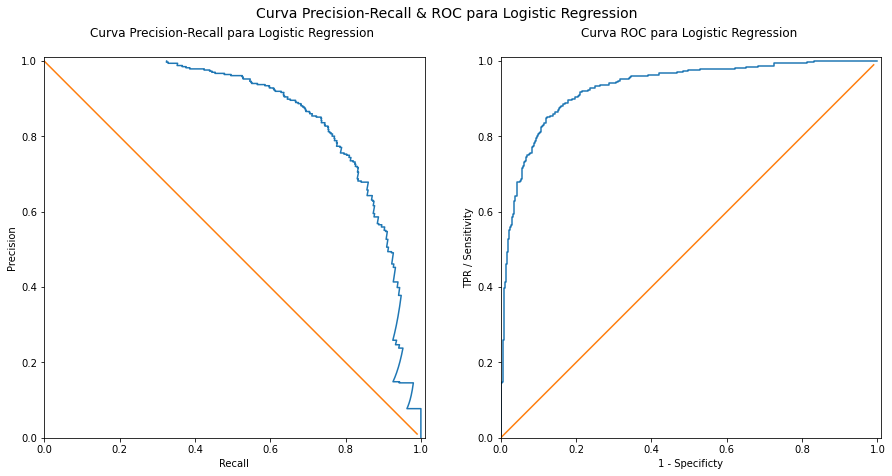



Area under Prec-Recall curve (AUC PR): 0.8571
Area under ROC curve (AUC ROC): 0.8083




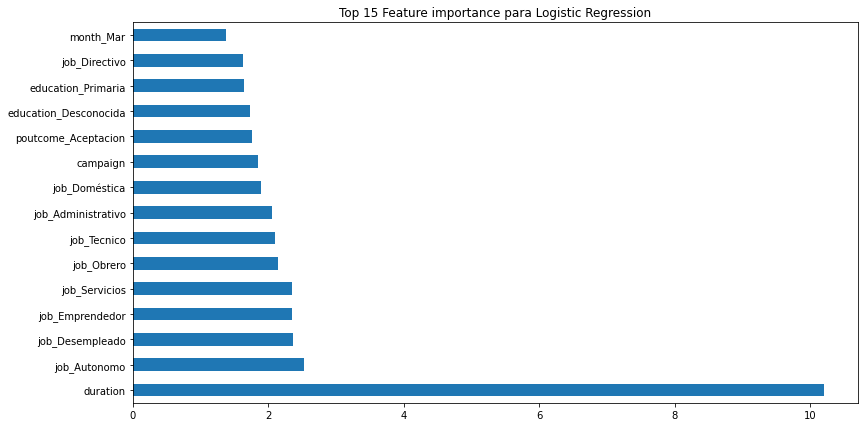



+++++++++++++++


Modelo:  K Neighbors Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       840
         1.0       0.63      0.66      0.64       336

    accuracy                           0.79      1176
   macro avg       0.75      0.75      0.75      1176
weighted avg       0.80      0.79      0.79      1176



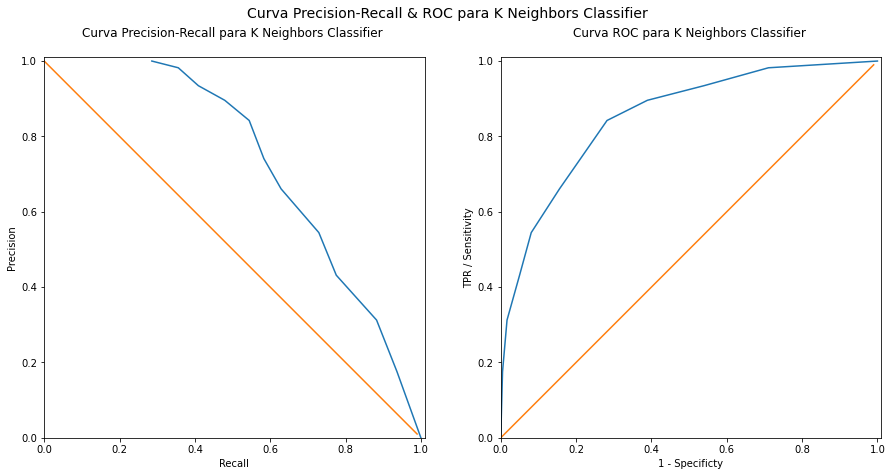



Area under Prec-Recall curve (AUC PR): 0.6289
Area under ROC curve (AUC ROC): 0.7524




+++++++++++++++


Modelo:  Gaussian Naive Bayes
---------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85       840
         1.0       0.63      0.64      0.64       336

    accuracy                           0.79      1176
   macro avg       0.74      0.75      0.74      1176
weighted avg       0.79      0.79      0.79      1176



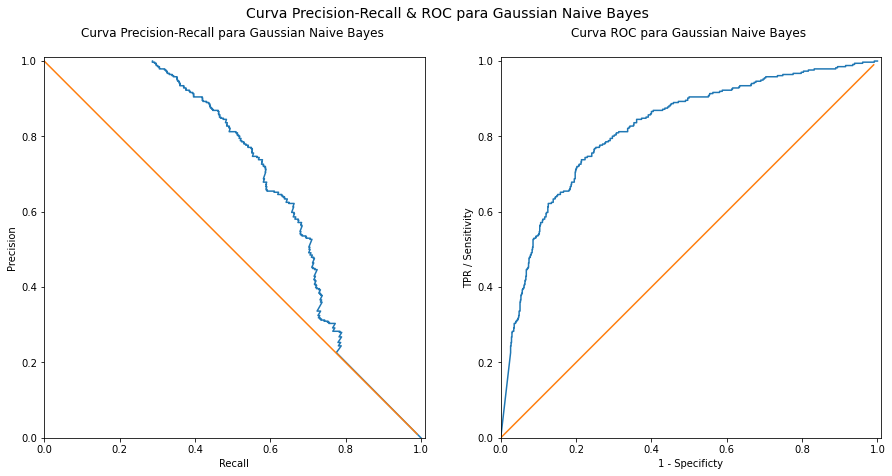



Area under Prec-Recall curve (AUC PR): 0.6324
Area under ROC curve (AUC ROC): 0.7455




+++++++++++++++


Modelo:  Neural Network
---------------------------------
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       840
         1.0       0.88      0.82      0.85       336

    accuracy                           0.92      1176
   macro avg       0.91      0.89      0.90      1176
weighted avg       0.92      0.92      0.92      1176



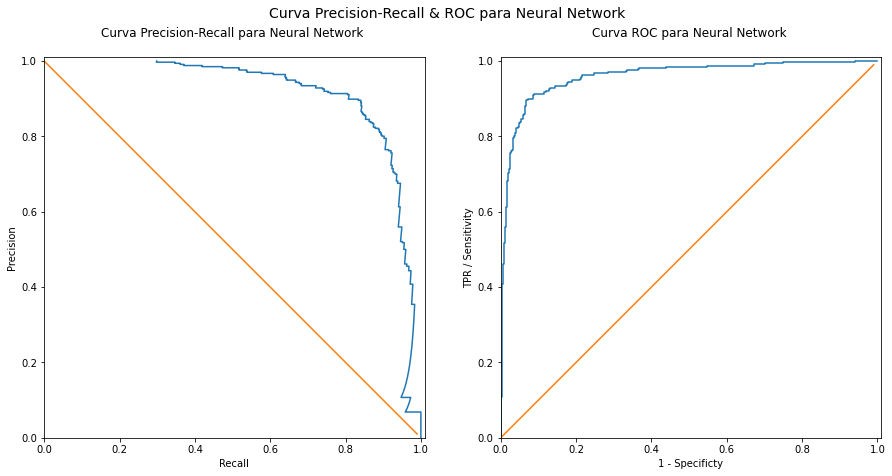



Area under Prec-Recall curve (AUC PR): 0.8818
Area under ROC curve (AUC ROC): 0.8887




+++++++++++++++


Modelo:  Random Forest
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       840
         1.0       0.87      0.78      0.82       336

    accuracy                           0.90      1176
   macro avg       0.89      0.87      0.88      1176
weighted avg       0.90      0.90      0.90      1176



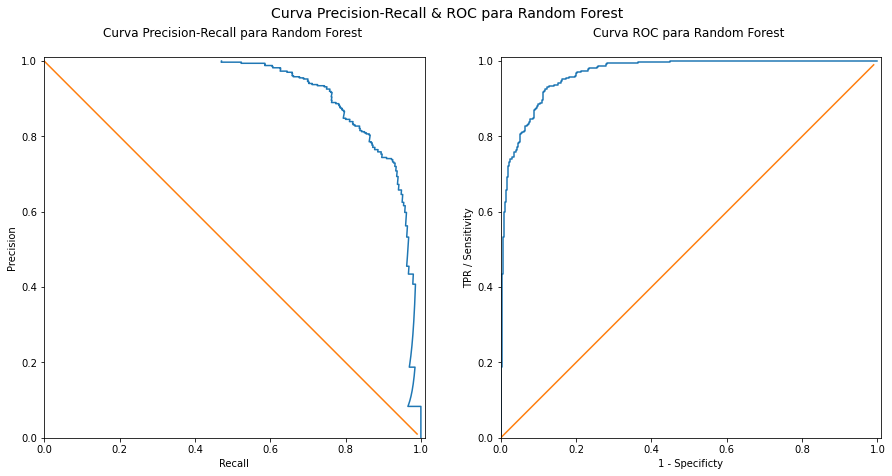



Area under Prec-Recall curve (AUC PR): 0.87
Area under ROC curve (AUC ROC): 0.8652




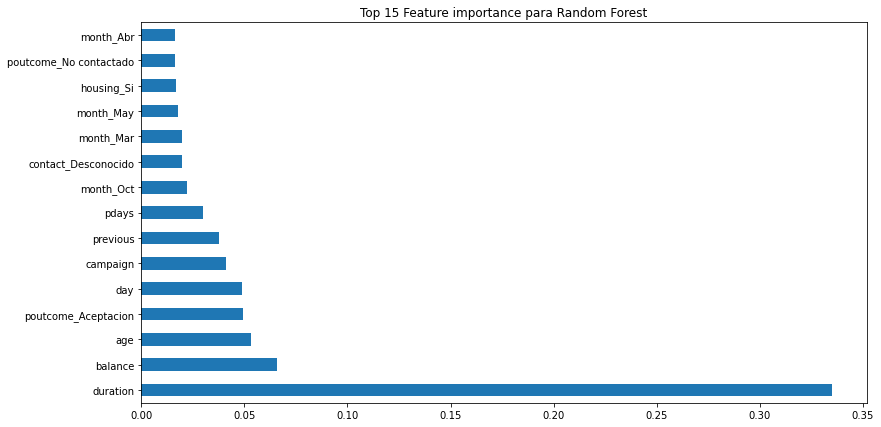



+++++++++++++++


Modelo:  Decision Tree
---------------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       840
         1.0       0.78      0.75      0.77       336

    accuracy                           0.87      1176
   macro avg       0.84      0.83      0.84      1176
weighted avg       0.87      0.87      0.87      1176



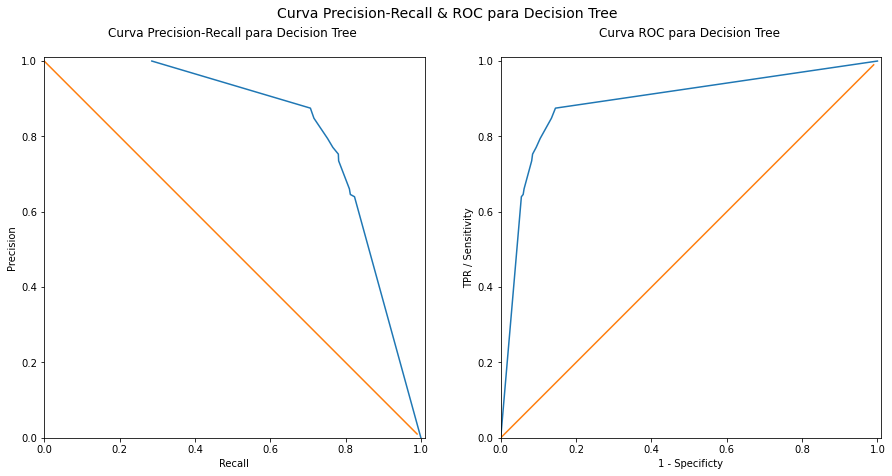



Area under Prec-Recall curve (AUC PR): 0.7809
Area under ROC curve (AUC ROC): 0.8342




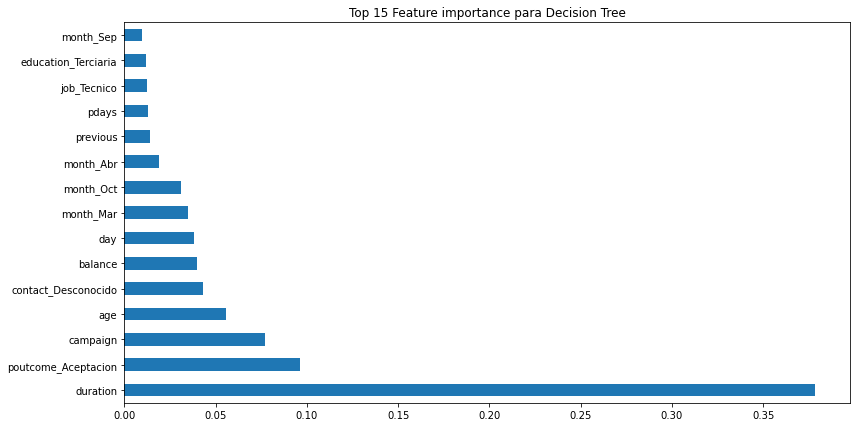



+++++++++++++++


Modelo:  Gradient Boost Classifier
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       840
         1.0       0.87      0.79      0.83       336

    accuracy                           0.91      1176
   macro avg       0.89      0.87      0.88      1176
weighted avg       0.91      0.91      0.91      1176



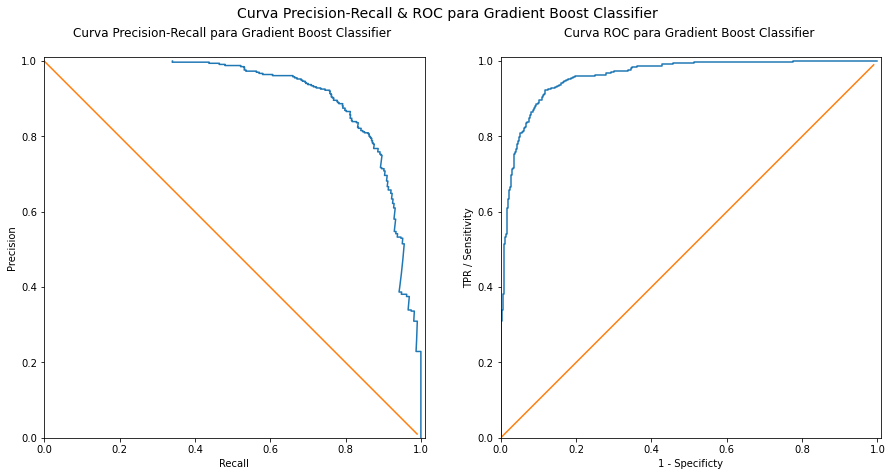



Area under Prec-Recall curve (AUC PR): 0.8669
Area under ROC curve (AUC ROC): 0.8729




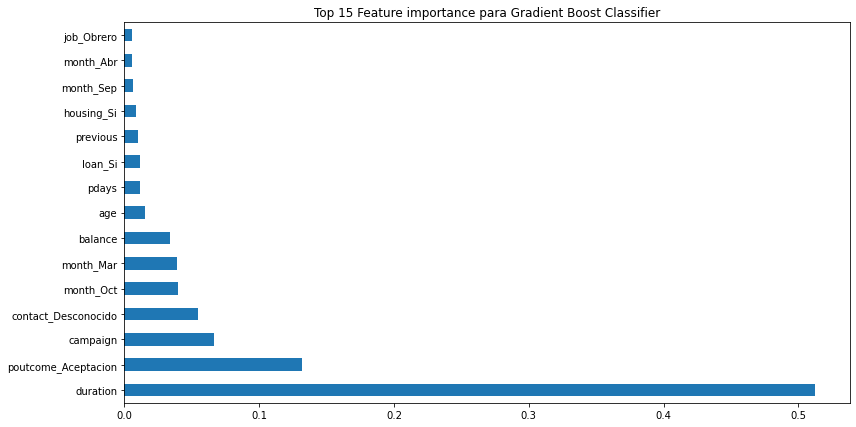



+++++++++++++++




In [110]:
data_model_resampled = run_models(models, X_res_train, X_res_test, y_res_train, y_res_test)

In [111]:
data_model_resampled

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.6607,0.8558,0.8571,0.8083,0.870532,0.871599,1.156250
K Neighbors Classifier,0.6607,0.6985,0.6289,0.7524,0.840992,0.791667,1.812500
Gaussian Naive Bayes,0.6399,0.6468,0.6324,0.7455,0.784829,0.790816,0.453125
Neural Network,0.8214,0.9168,0.8818,0.8887,0.989424,0.917517,20.062500
Random Forest,0.7768,0.9207,0.8700,0.8652,0.969365,0.903061,1.203125
Decision Tree,0.7530,0.7407,0.7809,0.8342,0.956601,0.869048,0.859375
Gradient Boost Classifier,0.7946,0.9116,0.8669,0.8729,0.911379,0.906463,1.015625


In [112]:
data_model

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Logistic Regression,0.2179,0.4599,0.6296,0.6006,0.904551,0.895357,1.531250
K Neighbors Classifier,0.0449,0.2725,0.5833,0.5204,0.893489,0.886514,3.843750
Gaussian Naive Bayes,0.4103,0.2791,0.2922,0.6406,0.851454,0.817981,0.921875
Neural Network,0.3590,0.4051,0.5000,0.6562,0.991783,0.885041,36.109375
Random Forest,0.1538,0.5200,0.5455,0.5686,0.943110,0.887988,1.640625
Decision Tree,0.4551,0.3490,0.4410,0.6901,0.962073,0.871039,1.000000
Gradient Boost Classifier,0.1282,0.3569,0.5556,0.5574,0.895070,0.887988,1.500000


Con el oversampling mejoraron los valores de AUC PR, AUC ROC y la detección de clase 1. 

Ahora se toman los 3 memores modelos y se los compara usando cross validation y tomando el tiempo de procesamiento y puntaje medio como criterios de evaluación


In [113]:
model_NN = MLPClassifier(max_iter = 800)
model_RF = RandomForestClassifier(min_samples_leaf = 3)
model_DT = DecisionTreeClassifier(min_samples_leaf = 3)
models = {'Neural Network' : model_NN, 'Random Forest' : model_RF, 'Decision Tree' : model_DT}

In [114]:
def run_cv_models(models, X, y, cv):
    
    data_models = []
    
    for key, value in models.items():
        t_start = process_time() 
        model = value
        
        model_score = cross_val_score(estimator = model, X = X, y = y, cv = cv)
        model_score_mean = model_score.mean()
        
        t_end = process_time()
        time_to_process = t_end - t_start
        data_model_run = pd.Series(data = [model_score_mean, time_to_process], \
                                   index = ['Model Score Mean', 'Time to Process'],\
                                   name = key)
        data_models.append(data_model_run)
    
    data_models = pd.DataFrame(data = data_models, columns = ['Model Score Mean', 'Time to Process'])
    
    return data_models
    

In [115]:
data_model_cv = run_cv_models(models, X_res, y_res, 5)

In [116]:
data_model_cv

,Model Score Mean,Time to Process
Neural Network,0.909923,106.734375
Random Forest,0.903791,1.984375
Decision Tree,0.861419,0.125000


Random Forest es el mejor modelo, por lo que se va a optimizar con Grid Search

In [117]:
RFC_params = { 'n_estimators' : [10, 50, 100, 250, 500], 'min_samples_leaf' : [3, 5, 10, 15], 'max_features' : ['auto', 'sqrt', 'log2']}
model_RFC_GS = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RFC_params)

In [118]:
model_RFC_GS.fit(X_res, y_res)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [3, 5, 10, 15],
                         'n_estimators': [10, 50, 100, 250, 500]})

In [119]:
# Puntaje del mejor modelo
model_RFC_GS.score(X_res, y_res)

0.9749872383869321

In [120]:
# Parametros del mejor modelo
model_RFC_GS.best_params_

{'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 250}

Corrida del modelo optimizado con los datos resampleados

In [131]:
model_RF_opt = RandomForestClassifier(min_samples_leaf = 3, n_estimators = 50, max_features = 'sqrt')
models = {'Random Forest Optimizado' : model_RF_opt}

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size = 0.3, random_state = 42, stratify = y_res)

Modelo:  Random Forest Optimizado
---------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       840
         1.0       0.89      0.77      0.83       336

    accuracy                           0.91      1176
   macro avg       0.90      0.87      0.88      1176
weighted avg       0.91      0.91      0.91      1176



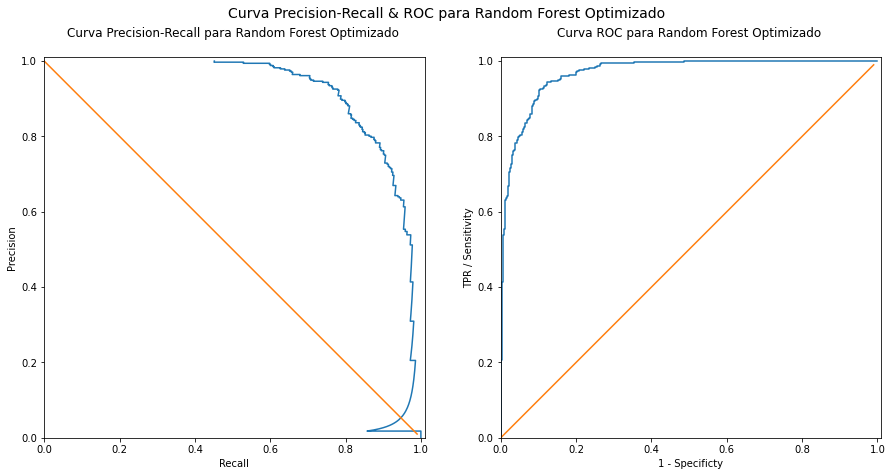



Area under Prec-Recall curve (AUC PR): 0.8904
Area under ROC curve (AUC ROC): 0.8679




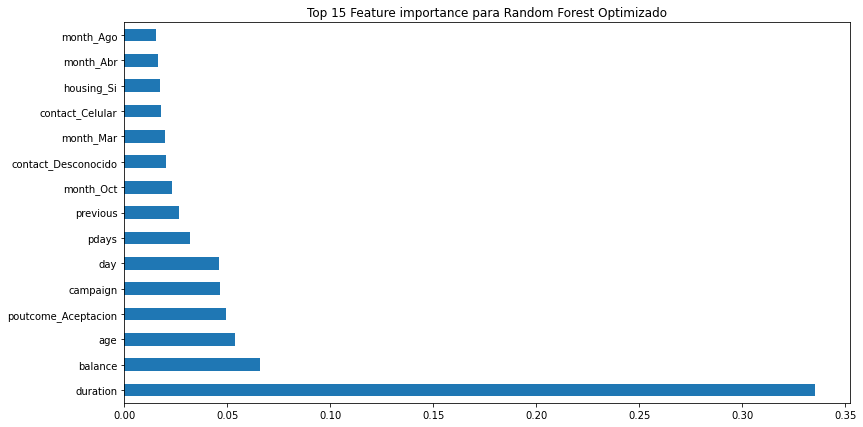



+++++++++++++++




In [132]:
data_model_optimized = run_models(models, X_train_res, X_test_res, y_train_res, y_test_res)

In [133]:
data_model_optimized

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Random Forest Optimizado,0.7738,0.9191,0.8904,0.8679,0.969365,0.908163,1.03125


El modelo tiene un buen puntaje de predicción en general y también buenos valores (0.75 a 0.90) de predicción de clase 1

Corrida del modelo optimizado tomando el set de testing original (sin resampling)

In [134]:
# Set de train de resampling, set de test del dataset original

model_RF_opt = RandomForestClassifier(min_samples_leaf = 3, n_estimators = 50, max_features = 'sqrt')
models = {'Random Forest Optimizado' : model_RF_opt}


Modelo:  Random Forest Optimizado
---------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      1201
         1.0       0.54      0.36      0.43       156

    accuracy                           0.89      1357
   macro avg       0.73      0.66      0.69      1357
weighted avg       0.88      0.89      0.88      1357



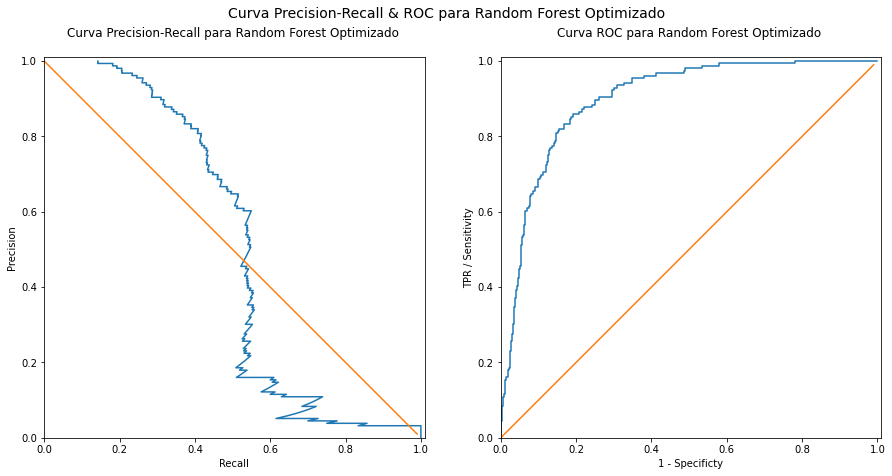



Area under Prec-Recall curve (AUC PR): 0.5437
Area under ROC curve (AUC ROC): 0.6599




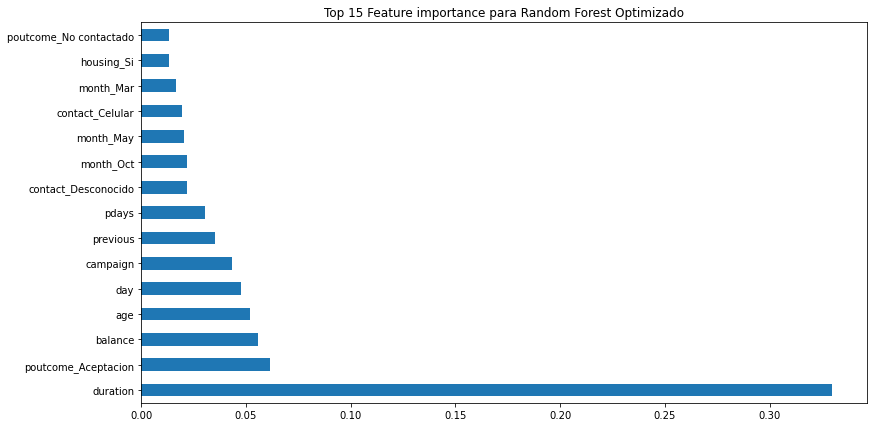



+++++++++++++++




In [135]:
data_model_optimized = run_models(models, X_res, X_test, y_res, y_test)

In [136]:
data_model_optimized

,+ class Recall,+ class Precission,AUC PR,AUC ROC,Train Score,Test Score,Time to Process
Random Forest Optimizado,0.359,0.5108,0.5437,0.6599,0.976008,0.891673,1.109375


El modelo también da buenos resultados al compararlo con el dataset original.

Al ser una buena herramienta descriptiva, se puede tomar como válida la feature_importance que entrega. El análisis de las variables más importantes y las acciones a tomar se deja para la presentación en ppt

In [137]:
X_train_res.shape

(2742, 51)

### Adicionales: celdas para sacar datos para ppt

In [138]:
variables = ['duration', 'Aceptacion']
df_acceptance = df_marketing.loc[:, variables].copy()
df_acceptance = df_acceptance.groupby(by = 'Aceptacion')
df_acceptance.mean()

,duration
Aceptacion,
0,226.347500
1,552.742802


In [155]:
variables = ['campaign', 'Aceptacion']
df_campaign = df_marketing.loc[:, variables].copy()
df_campaign = df_campaign.groupby(by = 'Aceptacion')
df_campaign.mean()

,campaign
Aceptacion,
0,2.862250
1,2.266795


In [140]:
df_campaign.std()

,campaign
Aceptacion,
0,3.212609
1,2.092071


Con 6 llamadas se cubre al 85% de resultados posibles (media más 1 desvío)

In [166]:
variables = ['job', 'Aceptacion']
df_campaign = df_marketing.loc[:, variables].copy()
df_campaign = pd.DataFrame(df_campaign.groupby(by = ['job', 'Aceptacion']).size())
df_campaign

0
job            Aceptacion     
Administrativo 0           420
               1            58
Autonomo       0           163
               1            20
Desconocido    0            31
               1             7
Desempleado    0           115
               1            13
Directivo      0           838
               1           131
Doméstica      0            98
               1            14
Emprendedor    0           153
               1            15
Estudiante     0            65
               1            19
Jubilado       0           176
               1            54
Obrero         0           877
               1            69
Servicios      0           379
               1            38
Tecnico        0           685
               1            83

In [170]:
variables = ['balance', 'Aceptacion']
df_balance = df_marketing.loc[:, variables].copy()
df_balance = df_balance.groupby(by = 'Aceptacion')
df_balance.mean()

,balance
Aceptacion,
0,1403.211750
1,1571.955854


In [171]:
df_marketing

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Aceptacion
0,30,Desempleado,Casado,Primaria,No,1787,No,No,Celular,19,Oct,79,1,-1,0,No contactado,0
1,33,Servicios,Casado,Secundaria,No,4789,Si,Si,Celular,11,May,220,1,339,4,Rechazo,0
2,35,Directivo,Soltero,Terciaria,No,1350,Si,No,Celular,16,Abr,185,1,330,1,Rechazo,0
3,30,Directivo,Casado,Terciaria,No,1476,Si,Si,Desconocido,3,Jun,199,4,-1,0,No contactado,0
4,59,Obrero,Casado,Secundaria,No,0,Si,No,Desconocido,5,May,226,1,-1,0,No contactado,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,Servicios,Casado,Secundaria,No,-333,Si,No,Celular,30,Jul,329,5,-1,0,No contactado,0
4517,57,Autonomo,Casado,Terciaria,Si,-3313,Si,Si,Desconocido,9,May,153,1,-1,0,No contactado,0
4518,57,Tecnico,Casado,Secundaria,No,295,No,No,Celular,19,Ago,151,11,-1,0,No contactado,0
4519,28,Obrero,Casado,Secundaria,No,1137,No,No,Celular,6,Feb,129,4,211,3,Otro,0
